<a href="https://colab.research.google.com/github/rominicky/diplocssoccomp/blob/main/trabajo_final_TBC2019al2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRABAJO INTEGRADOR
# DIPLOMATURA EN CIENCIAS SOCIALES COMPUTACIONALES
#### Estudiantes:
- Romina De León
- Magali Wettstein

In [1]:
!pip install seaborn
!pip install scikit-learn
!pip install KMeans
!pip install geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import geopandas as gpd

  Using cached kmeans-1.0.2.tar.gz (5.9 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for KMeans
Failed to build KMeans
  Running setup.py install for KMeans: started
  Running setup.py install for KMeans: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [19 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-310
  creating build\lib.win-amd64-cpython-310\kmeans
  copying kmeans\performance.py -> build\lib.win-amd64-cpython-310\kmeans
  copying kmeans\tests.py -> build\lib.win-amd64-cpython-310\kmeans
  copying kmeans\__init__.py -> build\lib.win-amd64-cpython-310\kmeans
  running egg_info
  writing kmeans.egg-info\PKG-INFO
  writing dependency_links to kmeans.egg-info\dependency_links.txt
  writing top-level names to kmeans.egg-info\top_level.txt
  reading manifest file 'kmeans.egg-info\SOURCES.txt'
  writing manifest file 'kmeans.egg-info\SOURCES.txt'
  copying kmeans\lib.c -> build\lib.win-amd64-cpython-310\kmeans
  running build_ext
  building 'kmeans/lib' extension
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Mic

In [2]:
!pip install openpyxl

El presente informe tiene por objetivo presentar una evaluación actualizada de la notificación de
casos de Tuberculosis (TB) en Argentina durante el período 2019-2021.
La información utilizada es
resultante de la notificación de casos que se realiza a través del Sistema Nacional de Vigilancia de
la Salud (SNVS 2.0), que permite el reporte individual de los casos por parte de los servicios de salud
a lo largo de todo el país, de manera remota e inmediata.
Para el presente documento se utilizó la información exportada 31 de agosto de 2023 del SNVS
2.0, el cual contiene los casos registrados y validados de 24 jurisdicciones del país para los años 2019,2020 y 2021.

In [3]:
# Cargar el conjunto de datos
fileurl = 'https://github.com/rominicky/diplocssoc/raw/main/TBC-NOTIFICACION_2019al2021.xlsx'

In [4]:
df = pd.read_excel(fileurl)

In [237]:
df.head(10)

,ID_EVENTO,FECHA_APERTURA,SEPI_APERTURA,FECHA_PAPEL,SEXO,NRO_DOC,FECHA_NACIMIENTO,EDAD_DIAGNOSTICO,IDPAISRESIDENCIA,PAIS_RESIDENCIA,...,ESQUEMA,TRATAMIENTO_2,FECHA_INICIO_TRAT,FECHA_FIN_TRAT,MOTIVO_CONSULTA,CURADO_MEJORADO,FECHA_ALTA_MEDICA,SE_DECLARA_PUEBLO_INDIGENA,ETNIA,CLASIFICACION_PANDEMIA
258051,5334200,2020-12-17,51,1956-03-25,F,12207122,1956-03-21,64.0,200.0,Argentina,...,NaN,2HRZE / 4HR,2021-12-29,NaT,NaN,NaN,NaT,NaN,NaN,Antes
258050,5334200,2020-12-17,51,1956-03-25,F,12207122,1956-03-21,64.0,200.0,Argentina,...,NaN,2HRZE / 4HR,2021-12-29,NaT,NaN,NaN,NaT,NaN,NaN,Antes
208818,1064658,2020-06-12,24,1979-12-05,M,27508918,1979-12-05,40.0,NaN,NaN,...,NaN,2HRZE / 4HR,2020-04-25,2020-06-12,NaN,NaN,NaT,NO,NaN,Antes
443519,531522,2019-01-23,4,1991-07-17,F,37273130,1991-07-17,27.0,200.0,Argentina,...,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,Antes
443518,531522,2019-01-23,4,1991-07-17,F,37273130,1991-07-17,27.0,200.0,Argentina,...,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,Antes
443520,531522,2019-01-23,4,1991-07-17,F,37273130,1991-07-17,27.0,200.0,Argentina,...,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,Antes
279076,8691865,2021-03-12,10,1997-01-15,M,40095050,1997-01-15,24.0,200.0,Argentina,...,NaN,2HRZ / 4HR,2021-02-23,2021-09-03,NaN,NaN,NaT,NaN,NaN,Antes
441502,14559880,2021-06-11,23,2010-02-11,F,20060132,1968-03-25,41.0,200.0,Argentina,...,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,Antes
441503,14559880,2021-06-11,23,2010-02-11,F,20060132,1968-03-25,41.0,200.0,Argentina,...,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,Antes
437741,13945132,2021-06-03,22,2010-06-02,M,20766716,1969-07-12,40.0,200.0,Argentina,...,NaN,Sin información,NaT,NaT,NaN,NaN,NaT,NaN,NaN,Antes


## Exploramos el Data Frame
¿Qué columnas tiene?¿Qué tipo de columnas son?

In [238]:
dimension = df.shape
print("Dimension del conjunto de datos:", dimension, "\n")

#Filas
print(f'Cantidad de filas: {df.shape[0]}\n')

#Columnas
print(f'Cantidad de columnas: {df.shape[1]} \n')

# Columnas
columnas = df.columns
print("Columnas:", columnas, "\n")

# Tipos de datos de las columnas
tipos = df.dtypes
print("Tipos de datos:", tipos, "\n")

#Info de datos nulos
nulos = df.info()
print("Valores Nulos:", nulos, "\n")

Dimension del conjunto de datos: (221059, 66) 

Cantidad de filas: 221059

Cantidad de columnas: 66 

Columnas: Index(['ID_EVENTO', 'FECHA_APERTURA', 'SEPI_APERTURA', 'FECHA_PAPEL', 'SEXO',
       'NRO_DOC', 'FECHA_NACIMIENTO', 'EDAD_DIAGNOSTICO', 'IDPAISRESIDENCIA',
       'PAIS_RESIDENCIA', 'ID_PROV_INDEC_RESIDENCIA', 'PROVINCIA_RESIDENCIA',
       'ID_DEPTO_INDEC_RESIDENCIA', 'DEPARTAMENTO_RESIDENCIA',
       'ID_LOC_INDEC_RESIDENCIA', 'LOCALIDAD_RESIDENCIA', 'CALLE_DOMICILIO',
       'NUMERO_DOMICILIO', 'PAIS_NACIMIENTO', 'PERS_PRIV_LIBERTAD',
       'SERVICIO_PENITENCIARIO', 'CLASIFICACION_MANUAL',
       'CLASIFICACION_AUTOMATICA', 'SEPI_SINTOMA', 'FECHA_CONSULTA',
       'SEPI_CONSULTA', 'FECHA_INICIO_SINTOMA', 'EMBARAZADA', 'INTERNADO',
       'FECHA_INTERNACION', 'ID_SNVS_SIGNO_SINTOMA', 'SIGNO_SINTOMA',
       'CLASIFICACION_EXTRAPULMONAR', 'FIS', 'SEPI_MUESTRA', 'FTM',
       'FECHA_ESTUDIO', 'DETERMINACION', 'RESULTADO', 'FECHA_RECEPCION',
       'ID_ESTABLECIMIENTO_DIAG', 

1. Transformación de datos:

Antes de comenzar el análisis, fue necesario realizar algunas transformaciones en los datos, como la conversión de fechas en formatos adecuados, la codificación de variables categóricas (GRUPO EDAD), la eliminación de columnas irrelevantes y el manejo de valores faltantes, el agrega de nuevas columnas con el calculo del tiempo de demora.

In [239]:
# Convertir la columna fechas a tipo de dato datetime y para manejar fechas fuera de rango es utilizar el argumento errors='coerce' al llamar a pd.to_datetime().
df['FECHA_DIAG'] = pd.to_datetime(df['FECHA_DIAG'], errors='coerce')
df['FECHA_PAPEL'] = pd.to_datetime(df['FECHA_PAPEL'], errors='coerce')
df['FECHA_NACIMIENTO'] = pd.to_datetime(df['FECHA_NACIMIENTO'], errors='coerce')
df['FECHA_CONSULTA'] = pd.to_datetime(df['FECHA_CONSULTA'], errors='coerce')
df['FECHA_INICIO_SINTOMA'] = pd.to_datetime(df['FECHA_INICIO_SINTOMA'], errors='coerce')
df['FECHA_INTERNACION'] = pd.to_datetime(df['FECHA_INTERNACION'], errors='coerce')
df['FIS'] = pd.to_datetime(df['FIS'], errors='coerce')
df['FTM'] = pd.to_datetime(df['FTM'], errors='coerce')
df['FECHA_ESTUDIO'] = pd.to_datetime(df['FECHA_ESTUDIO'], errors='coerce')
df['FECHA_RECEPCION'] = pd.to_datetime(df['FECHA_RECEPCION'], errors='coerce')
df['FECHA_DIAG'] = pd.to_datetime(df['FECHA_DIAG'], errors='coerce')
df['FECHA_INICIO_TRAT'] = pd.to_datetime(df['FECHA_INICIO_TRAT'], errors='coerce')
df['FECHA_FIN_TRAT'] = pd.to_datetime(df['FECHA_FIN_TRAT'], errors='coerce')

In [240]:
# Reemplaza los valores faltantes en 'FECHA_DIAG' con los de 'FTM'
df['FECHA_DIAG'].fillna(df['FTM'], inplace=True)

# Reemplaza los valores faltantes en 'FECHA_DIAG' con los de 'FECHA_ESTUDIO'
df['FECHA_DIAG'].fillna(df['FECHA_ESTUDIO'], inplace=True)

# Reemplaza los valores faltantes en 'FECHA_DIAG' con los de 'FECHA_INICIO_TRAT'
df['FECHA_DIAG'].fillna(df['FECHA_INICIO_TRAT'], inplace=True)

# Ahora 'FECHA_DIAG' contiene los valores de 'FTM', 'FECHA_ESTUDIO' o 'FECHA_INICIO_TRAT' en ese orden de prioridad

# Reemplaza los valores faltantes en 'FECHA_PAPEL' con los de 'FECHA_APERTURA'
df['FECHA_PAPEL'].fillna(df['FECHA_APERTURA'], inplace=True)

Eliminar valores faltantes no siempre es la mejor opción, ya que puede resultar en una pérdida de información si hay datos valiosos en otras columnas de las filas eliminadas. En lugar de eliminar las filas con valores faltantes, se reemplaza esos valores con una estimación basada en los datos existentes. Por ejemplo, puedes usar la media, la mediana o algún otro método de imputación.

In [241]:
# Imputar los valores faltantes en 'EDAD_DIAGNOSTICO' con la mediana
median_age = df['EDAD_DIAGNOSTICO'].median()
df['EDAD_DIAGNOSTICO'].fillna(median_age, inplace=True)

In [242]:
# Ordena el DataFrame por 'FECHA_PAPEL' de manera ascendente
df.sort_values(by='FECHA_PAPEL', ascending=True, inplace=True)

# Elimina duplicados basados en todas las columnas excepto 'FECHA_PAPEL'
df.drop_duplicates(subset=df.columns.difference(['FECHA_PAPEL']), keep='first', inplace=True)


AISLAMIENTO SOCIAL PREVENTIVO Y OBLIGATORIO
Decreto 297/2020
DECNU-2020-297-APN-PTE - Disposiciones.
https://www.boletinoficial.gob.ar/detalleAviso/primera/227042/20200320

ARTÍCULO 2º.- Durante la vigencia del “aislamiento social, preventivo y obligatorio”, las personas deberán permanecer en sus residencias habituales o en la residencia en que se encuentren a las 00:00 horas del día 20 de marzo de 2020, momento de inicio de la medida dispuesta.

In [243]:
# Fecha de inicio de la pandemia
fecha_inicio_pandemia = pd.to_datetime('2020-03-20')

# Nueva columna llamada 'CLASIFICACION_PANDEMIA'
# con valores 'Antes' para fechas anteriores a la pandemia y 'Despues' para fechas posteriores o durante la pandemia
df['CLASIFICACION_PANDEMIA'] = df['FECHA_PAPEL'].apply(lambda x: 'Antes' if x < fecha_inicio_pandemia else 'Despues')


In [244]:
categorias_unicas = df['RESULTADO'].unique()
print(categorias_unicas)

['Positivo (+++)' 'Positivo (++)' nan 'Positivo' 'Negativo'
 'Se detecta patrón de bandas específicas' 'Positivo (+)' 'Sensible'
 'Se detecta ADN del complejo Mycobacterium tuberculosis' 'Resistente'
 'Indeterminado'
 'MTB detectado medio, resistencia a rifampicina no detectada'
 'No se detecta mutación' 'Positivo (1 a 19 colonias)'
 'Se detecta mutacion inhA'
 'No se detecta ADN del complejo Mycobacterium tuberculosis'
 'Se detecta mutación rpoB531' 'Contaminado' 'No procesada'
 'MTB detectado, resistencia a rifampicina no detectada'
 'Se detecta mutación katG315' 'En estudio' 'Positiva (contable)'
 'MTB detectado bajo, resistencia a rifampicina no detectada'
 'No se detecta patrón de bandas específicas' 'Se detecta mutacion katG'
 'MTB no detectado' 'MTB detectado, resistencia a rifampicina detectada'
 'MTB detectada. Resist a RIF NO detectada. Resist a INH NO detectada'
 'Se detecta mutacion gyrA' 'Se detecta mutacion rpoB'
 'Se detecta mutación rpoB526'
 'MTB detectado bajo, resist

El Data Frame tiene duplicados porque descarga para cada evento una fila por cada toma de muestra que se envio a analizar para confirmar el evento o como control del tratamiento

In [273]:
base= df.drop_duplicates(subset=['NRO_DOC', 'FECHA_PAPEL','RESULTADO'])

In [274]:
dimension = base.shape
print("Dimension del conjunto de datos:", dimension, "\n")


Dimension del conjunto de datos: (66961, 66) 



In [275]:
#Volvemos a eliminar duplicados segun clasificacion del caso
base= df.drop_duplicates(subset=['NRO_DOC', 'FECHA_PAPEL'])

In [276]:
dimension = base.shape
print("Dimension del conjunto de datos:", dimension, "\n")

Dimension del conjunto de datos: (37596, 66) 



In [277]:
# Extrae el año de notificación
base['ANIO_NOTIFICACION'] = pd.to_datetime(base['FECHA_PAPEL']).dt.year

# Nos quedamos solo con los años 2019-2020-2021
base = base.query('ANIO_NOTIFICACION in [2019, 2020, 2021]')

C:\Users\RominaSoledadDeLeon\AppData\Local\Temp\ipykernel_25796\1583826920.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [278]:
# Define los límites de los rangos de edad
rangos_edad = [0, 18, 30, 45, 60, float('inf')]

# Define las etiquetas para los grupos de edad
etiquetas_edad = ['0-18', '19-30', '31-45', '46-60', '61+']

# Crea la columna 'GRUPO_EDAD' utilizando la función cut para agrupar las edades
base['GRUPO_EDAD'] = pd.cut(df['EDAD_DIAGNOSTICO'], bins=rangos_edad, labels=etiquetas_edad)

In [279]:
base.head(10)

,ID_EVENTO,FECHA_APERTURA,SEPI_APERTURA,FECHA_PAPEL,SEXO,NRO_DOC,FECHA_NACIMIENTO,EDAD_DIAGNOSTICO,IDPAISRESIDENCIA,PAIS_RESIDENCIA,...,FECHA_INICIO_TRAT,FECHA_FIN_TRAT,MOTIVO_CONSULTA,CURADO_MEJORADO,FECHA_ALTA_MEDICA,SE_DECLARA_PUEBLO_INDIGENA,ETNIA,CLASIFICACION_PANDEMIA,ANIO_NOTIFICACION,GRUPO_EDAD
30775,578403,2019-05-07,19,2019-01-01,F,94620094,1983-05-06,35.0,200.0,Argentina,...,2018-10-30,2019-11-06,NaN,ND,NaT,NO,NaN,Antes,2019,31-45
420798,541171,2019-02-13,7,2019-01-01,M,40178300,1992-01-23,26.0,200.0,Argentina,...,2019-01-07,NaT,NaN,NaN,NaT,NO,NaN,Antes,2019,19-30
458750,632744,2019-08-14,33,2019-01-01,F,25099300,1976-08-20,42.0,200.0,Argentina,...,2019-01-08,2019-10-16,Sintomático Respiratorio,SI,2019-10-16,NO,NaN,Antes,2019,31-45
455976,630149,2019-08-09,32,2019-01-01,F,32747215,1987-09-05,31.0,200.0,Argentina,...,2019-01-07,NaT,NaN,SI,2019-08-09,NO,NaN,Antes,2019,31-45
34298,561497,2019-04-01,14,2019-01-01,M,16366442,1963-01-06,55.0,200.0,Argentina,...,2019-01-10,NaT,NaN,SI,2019-12-23,NO,NaN,Antes,2019,46-60
420640,576578,2019-05-02,18,2019-01-01,F,57057179,2018-07-09,0.0,200.0,Argentina,...,NaT,NaT,NaN,NaN,NaT,NO,NaN,Antes,2019,NaN
49274,609924,2019-07-04,27,2019-01-01,M,93715886,1966-04-23,52.0,200.0,Argentina,...,2019-01-03,NaT,NaN,NaN,NaT,NaN,NaN,Antes,2019,46-60
20772,564971,2019-04-08,15,2019-01-01,M,94400713,1998-09-20,20.0,200.0,Argentina,...,NaT,NaT,NaN,NaN,NaT,NO,NaN,Antes,2019,19-30
463326,541079,2019-02-13,7,2019-01-01,NaN,900437190,NaT,33.0,200.0,Argentina,...,2019-01-02,NaT,NaN,NaN,NaT,NaN,NaN,Antes,2019,31-45
44174,614850,2019-07-16,29,2019-01-01,F,18824808,1980-04-14,38.0,200.0,Argentina,...,NaT,NaT,NaN,NaN,NaT,NaN,NaN,Antes,2019,31-45


In [280]:
# Calcula el tiempo de demora en días (puede ajustarse a otra unidad de tiempo)
# primero hago la diferencia entre 'FECHA_DIAG' y 'FECHA_INICIO_SINTOMA'
base['TIEMPO_DEMORA'] = (base['FECHA_DIAG'] - base['FECHA_INICIO_SINTOMA']).dt.days
base['TIEMPO_DEMORA_TTO'] = (base['FECHA_FIN_TRAT'] - base['FECHA_INICIO_TRAT']).dt.days

# ahora calculo la media de los valores no negativos
media_tiempo_demora = base[base['TIEMPO_DEMORA'] >= 0]['TIEMPO_DEMORA'].mean()
media_tiempo_demora_tto = base[base['TIEMPO_DEMORA_TTO'] >= 0]['TIEMPO_DEMORA_TTO'].mean()
# para los valores negativos reemplazo por la media
base['TIEMPO_DEMORA'] = base['TIEMPO_DEMORA'].apply(lambda x: x if x >= 0 else media_tiempo_demora)
base['TIEMPO_DEMORA_TTO'] = base['TIEMPO_DEMORA_TTO'].apply(lambda x: x if x >= 0 else media_tiempo_demora_tto)

In [281]:
print(base['TIEMPO_DEMORA'].head())

30775      18.000000
420798     37.553203
458750     37.553203
455976     37.553203
34298     333.000000
Name: TIEMPO_DEMORA, dtype: float64


In [282]:
print(base['TIEMPO_DEMORA_TTO'].head())

30775     372.000000
420798    205.512958
458750    281.000000
455976    205.512958
34298     205.512958
Name: TIEMPO_DEMORA_TTO, dtype: float64



2. Análisis descriptivo:
- Resumen estadístico de variables numéricas (edad, tiempo de diagnóstico, etc.).
- Distribuciones de variables categóricas (sexo, país de residencia, localidad, clasificacion del caso, resultado de tratamiento etc.).
- Gráficos de dispersión para identificar tendencias.
- Histogramas para visualizar la distribución de la edad de diagnóstico antes y después de la pandemia.
- Box plots para identificar valores atípicos.
-Análisis de correlación para determinar relaciones entre variables.

Si hizo una descripción de las variables tipo objeto, la cantidad de filas que tienen el dato (count) cantidad de valores unicos dentro de cada variable(unique) la categoria que se aparece con mayor frecuencia y la cantidad de veces que aparece (top y freq)
## De este analisis podemos ver que conviene quedarnos solo con las variable del tipo obejto que son:????

In [283]:
base.describe(include=['O'])


,SEXO,NRO_DOC,PAIS_RESIDENCIA,PROVINCIA_RESIDENCIA,ID_DEPTO_INDEC_RESIDENCIA,DEPARTAMENTO_RESIDENCIA,ID_LOC_INDEC_RESIDENCIA,LOCALIDAD_RESIDENCIA,CALLE_DOMICILIO,NUMERO_DOMICILIO,...,RESULTADO_TRATAMIENTO,CLASIF_INICIO_TRAT,MODALIDAD_TRAT,ESQUEMA,TRATAMIENTO_2,MOTIVO_CONSULTA,CURADO_MEJORADO,SE_DECLARA_PUEBLO_INDIGENA,ETNIA,CLASIFICACION_PANDEMIA
count,36391,36448,34567,36303,36448,35281,36203,36203,34753,28725,...,29587,28857,29587,1120,29587,1794,6689,11701,202,36448
unique,4,34031,5,25,484,409,1348,1576,19633,5733,...,7,6,4,820,6,4,3,2,14,2
top,M,38015536,Argentina,Buenos Aires,6427,Capital,,*SIN DATO* (*SIN DATO*),0,0,...,Tratamiento completo,Nuevo,Autoadministrado,3HZRSE/5HRE,2HRZE / 4HR,Sintomático Respiratorio,SI,NO,Wichí,Despues
freq,20503,6,34554,18849,2176,2774,9719,9719,332,4638,...,11440,25330,14069,49,18942,1490,4422,11413,70,20377


In [284]:
df.columns

Index(['ID_EVENTO', 'FECHA_APERTURA', 'SEPI_APERTURA', 'FECHA_PAPEL', 'SEXO',
       'NRO_DOC', 'FECHA_NACIMIENTO', 'EDAD_DIAGNOSTICO', 'IDPAISRESIDENCIA',
       'PAIS_RESIDENCIA', 'ID_PROV_INDEC_RESIDENCIA', 'PROVINCIA_RESIDENCIA',
       'ID_DEPTO_INDEC_RESIDENCIA', 'DEPARTAMENTO_RESIDENCIA',
       'ID_LOC_INDEC_RESIDENCIA', 'LOCALIDAD_RESIDENCIA', 'CALLE_DOMICILIO',
       'NUMERO_DOMICILIO', 'PAIS_NACIMIENTO', 'PERS_PRIV_LIBERTAD',
       'SERVICIO_PENITENCIARIO', 'CLASIFICACION_MANUAL',
       'CLASIFICACION_AUTOMATICA', 'SEPI_SINTOMA', 'FECHA_CONSULTA',
       'SEPI_CONSULTA', 'FECHA_INICIO_SINTOMA', 'EMBARAZADA', 'INTERNADO',
       'FECHA_INTERNACION', 'ID_SNVS_SIGNO_SINTOMA', 'SIGNO_SINTOMA',
       'CLASIFICACION_EXTRAPULMONAR', 'FIS', 'SEPI_MUESTRA', 'FTM',
       'FECHA_ESTUDIO', 'DETERMINACION', 'RESULTADO', 'FECHA_RECEPCION',
       'ID_ESTABLECIMIENTO_DIAG', 'ESTABLECIMIENTO_DIAG', 'ID_LOC_INDEC_DIAG',
       'LOCALIDAD_DIAG', 'ANTECEDENTE_EPIDEMIOLOGICO',
       'TIPO

In [285]:
# estadísticas descriptivas
descripcion = base[['TIEMPO_DEMORA', 'EDAD_DIAGNOSTICO', 'TIEMPO_DEMORA_TTO']].describe()

print(descripcion)

       TIEMPO_DEMORA  EDAD_DIAGNOSTICO  TIEMPO_DEMORA_TTO
count   36448.000000      36448.000000       36448.000000
mean       37.553203         37.117208         205.512958
std       281.620714         21.554623         102.894453
min         0.000000       -944.000000           0.000000
25%         0.000000         23.000000         205.512958
50%        37.553203         34.000000         205.512958
75%        37.553203         50.000000         205.512958
max     43851.000000        919.000000        9919.000000


se puede ver que hay valores negativos...no deberia los investigamos
## tomar decision de que hacer los eliminamos?
modifique antes para eliminar el error negativo en tiempo demora

In [286]:
# Contar cuántos valores negativos hay en 'TIEMPO_DEMORA'
valores_negativos_tiempo = (base['TIEMPO_DEMORA'] < 0).sum()

# Contar cuántos valores negativos hay en 'EDAD'
valores_negativos_edad = (base['EDAD_DIAGNOSTICO'] < 0).sum()

# Contar cuántos valores mayores de 90 años hay en 'EDAD'
valores_negativos_edad_90 = (base['EDAD_DIAGNOSTICO'] > 90).sum()

# Contar cuántos valores extremos tiempo demora diagnostico 365 días
valores_demora_emayor_365 = (base['TIEMPO_DEMORA'] > 365).sum()

# Contar cuántos valores extremos tiempo demora diagnostico 365 días
valores_demora_tratamiento_365 = (base['TIEMPO_DEMORA_TTO'] > 365).sum()

print(f'Valores negativos en TIEMPO_DEMORA: {valores_negativos_tiempo}')
print(f'Valores negativos en EDAD: {valores_negativos_edad}')
print(f'Valores negativos en EDAD mayor a 90: {valores_negativos_edad_90}')
print(f'Valores negativos en demora diagnostico mayor 365: {valores_demora_emayor_365}')
print(f'Valores negativos demora completar tto mayor a 365: {valores_demora_tratamiento_365}')

Valores negativos en TIEMPO_DEMORA: 0
Valores negativos en EDAD: 8
Valores negativos en EDAD mayor a 90: 39
Valores negativos en demora diagnostico mayor 365: 383
Valores negativos demora completar tto mayor a 365: 1101


Eliminamos valores atipicos

In [287]:
base = base.drop(base[base['EDAD_DIAGNOSTICO'] > 90].index)
base = base.drop(base[base['EDAD_DIAGNOSTICO'] < 0].index)
base = base.drop(base[base['TIEMPO_DEMORA'] > 365].index)
base = base.drop(base[base['TIEMPO_DEMORA_TTO'] > 365].index)

In [288]:
dimension = base.shape
print("Dimension del conjunto de datos:", dimension, "\n")


Dimension del conjunto de datos: (34945, 70) 



In [289]:
# estadísticas descriptivas
descripcion = base[['TIEMPO_DEMORA', 'EDAD_DIAGNOSTICO', 'TIEMPO_DEMORA_TTO']].describe()

print(descripcion)

       TIEMPO_DEMORA  EDAD_DIAGNOSTICO  TIEMPO_DEMORA_TTO
count   34945.000000      34945.000000       34945.000000
mean       28.598339         37.163972         197.103110
std        37.647539         18.712782          59.548040
min         0.000000          0.000000           0.000000
25%         0.000000         23.000000         204.000000
50%        37.553203         34.000000         205.512958
75%        37.553203         51.000000         205.512958
max       365.000000         90.000000         365.000000


In [290]:
valores_negativos_edad = base[base['EDAD_DIAGNOSTICO'] > 91]
valores_negativos_edad

,ID_EVENTO,FECHA_APERTURA,SEPI_APERTURA,FECHA_PAPEL,SEXO,NRO_DOC,FECHA_NACIMIENTO,EDAD_DIAGNOSTICO,IDPAISRESIDENCIA,PAIS_RESIDENCIA,...,MOTIVO_CONSULTA,CURADO_MEJORADO,FECHA_ALTA_MEDICA,SE_DECLARA_PUEBLO_INDIGENA,ETNIA,CLASIFICACION_PANDEMIA,ANIO_NOTIFICACION,GRUPO_EDAD,TIEMPO_DEMORA,TIEMPO_DEMORA_TTO


In [291]:
# Compruebo si se realizo bien el cambio
valores_negativos = base[base['EDAD_DIAGNOSTICO'] < 0]

# Hago un if para que se actualizo bien
if valores_negativos.empty:
    print("Todos los valores negativos en 'EDAD_DIAGNOSTICO' se han actualizado correctamente.")
else:
    print("Aún quedan valores negativos en 'EDAD_DIAGNOSTICO'. Revisa la actualización.")


Todos los valores negativos en 'EDAD_DIAGNOSTICO' se han actualizado correctamente.


In [292]:
base.head(10)

,ID_EVENTO,FECHA_APERTURA,SEPI_APERTURA,FECHA_PAPEL,SEXO,NRO_DOC,FECHA_NACIMIENTO,EDAD_DIAGNOSTICO,IDPAISRESIDENCIA,PAIS_RESIDENCIA,...,MOTIVO_CONSULTA,CURADO_MEJORADO,FECHA_ALTA_MEDICA,SE_DECLARA_PUEBLO_INDIGENA,ETNIA,CLASIFICACION_PANDEMIA,ANIO_NOTIFICACION,GRUPO_EDAD,TIEMPO_DEMORA,TIEMPO_DEMORA_TTO
420798,541171,2019-02-13,7,2019-01-01,M,40178300,1992-01-23,26.0,200.0,Argentina,...,NaN,NaN,NaT,NO,NaN,Antes,2019,19-30,37.553203,205.512958
458750,632744,2019-08-14,33,2019-01-01,F,25099300,1976-08-20,42.0,200.0,Argentina,...,Sintomático Respiratorio,SI,2019-10-16,NO,NaN,Antes,2019,31-45,37.553203,281.000000
455976,630149,2019-08-09,32,2019-01-01,F,32747215,1987-09-05,31.0,200.0,Argentina,...,NaN,SI,2019-08-09,NO,NaN,Antes,2019,31-45,37.553203,205.512958
34298,561497,2019-04-01,14,2019-01-01,M,16366442,1963-01-06,55.0,200.0,Argentina,...,NaN,SI,2019-12-23,NO,NaN,Antes,2019,46-60,333.000000,205.512958
420640,576578,2019-05-02,18,2019-01-01,F,57057179,2018-07-09,0.0,200.0,Argentina,...,NaN,NaN,NaT,NO,NaN,Antes,2019,NaN,37.553203,205.512958
49274,609924,2019-07-04,27,2019-01-01,M,93715886,1966-04-23,52.0,200.0,Argentina,...,NaN,NaN,NaT,NaN,NaN,Antes,2019,46-60,0.000000,205.512958
20772,564971,2019-04-08,15,2019-01-01,M,94400713,1998-09-20,20.0,200.0,Argentina,...,NaN,NaN,NaT,NO,NaN,Antes,2019,19-30,7.000000,205.512958
463326,541079,2019-02-13,7,2019-01-01,NaN,900437190,NaT,33.0,200.0,Argentina,...,NaN,NaN,NaT,NaN,NaN,Antes,2019,31-45,37.553203,205.512958
44174,614850,2019-07-16,29,2019-01-01,F,18824808,1980-04-14,38.0,200.0,Argentina,...,NaN,NaN,NaT,NaN,NaN,Antes,2019,31-45,37.553203,205.512958
261099,523015,2019-01-02,1,2019-01-02,M,30562155,1983-10-02,35.0,200.0,Argentina,...,NaN,SI,2019-07-23,NO,NaN,Antes,2019,31-45,37.553203,288.000000


Para poder realizar trabajo con GeoJson se realizó cambio dentro de provincias de residencia a la Ciudad Autónoma de BUenos Aires por CABA

In [293]:
base['PROVINCIA_RESIDENCIA'] = base['PROVINCIA_RESIDENCIA'].replace('CABA', 'Ciudad Autónoma de Buenos Aires')

# Hacemos una serie de graficos y tablas para interpretar los datos

> Bloque con sangría



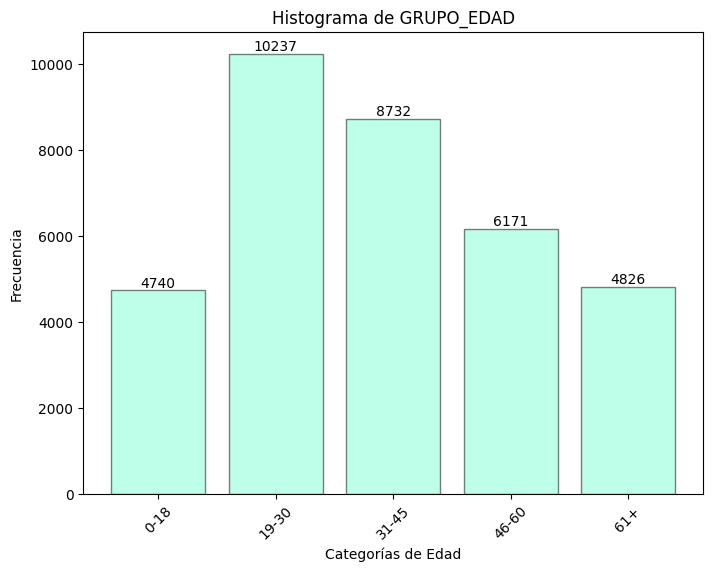

In [308]:
cant_grupo_edad = base['GRUPO_EDAD'].value_counts().sort_index()

# Crear el histograma de conteo
plt.figure(figsize=(8, 6))
bar = plt.bar(cant_grupo_edad.index, cant_grupo_edad.values, edgecolor='black', alpha=0.5, color='aquamarine')
plt.title('Histograma de GRUPO_EDAD')
plt.xlabel('Categorías de Edad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.bar_label(bar, fmt='%d', label_type='edge', fontsize=10, color='black')
plt.show()


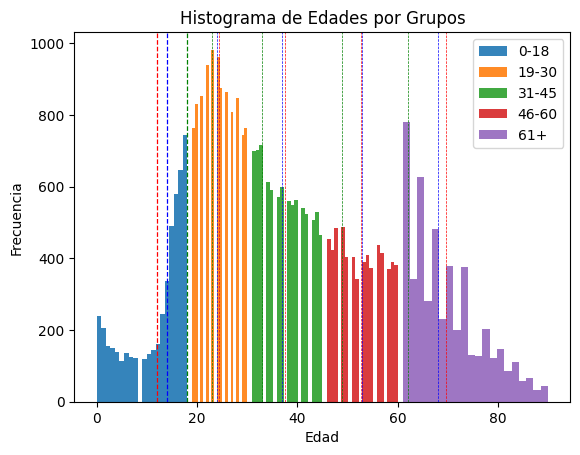

In [267]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de que los valores en la columna 'EDAD_DIAGNOSTICO' sean números
base['EDAD_DIAGNOSTICO'] = pd.to_numeric(base['EDAD_DIAGNOSTICO'], errors='coerce')

# Crear subconjuntos de datos para cada categoría
edad_0_18 = base[(base['EDAD_DIAGNOSTICO'] >= 0) & (base['EDAD_DIAGNOSTICO'] <= 18)]
edad_19_30 = base[(base['EDAD_DIAGNOSTICO'] >= 19) & (base['EDAD_DIAGNOSTICO'] <= 30)]
edad_31_45 = base[(base['EDAD_DIAGNOSTICO'] >= 31) & (base['EDAD_DIAGNOSTICO'] <= 45)]
edad_46_60 = base[(base['EDAD_DIAGNOSTICO'] >= 46) & (base['EDAD_DIAGNOSTICO'] <= 60)]
edad_61 = base[(base['EDAD_DIAGNOSTICO'] >= 61)]

# Calcular la media, moda y mediana de cada categoría
media_edad_0_18 = edad_0_18['EDAD_DIAGNOSTICO'].mean()
moda_edad_0_18 = edad_0_18['EDAD_DIAGNOSTICO'].mode().values[0]
mediana_edad_0_18 = edad_0_18['EDAD_DIAGNOSTICO'].median()

media_edad_19_30 = edad_19_30['EDAD_DIAGNOSTICO'].mean()
moda_edad_19_30 = edad_19_30['EDAD_DIAGNOSTICO'].mode().values[0]
mediana_edad_19_30 = edad_19_30['EDAD_DIAGNOSTICO'].median()

media_edad_31_45 = edad_31_45['EDAD_DIAGNOSTICO'].mean()
moda_edad_31_45 = edad_31_45['EDAD_DIAGNOSTICO'].mode().values[0]
mediana_edad_31_45 = edad_31_45['EDAD_DIAGNOSTICO'].median()

media_edad_46_60 = edad_46_60['EDAD_DIAGNOSTICO'].mean()
moda_edad_46_60 = edad_46_60['EDAD_DIAGNOSTICO'].mode().values[0]
mediana_edad_46_60 = edad_46_60['EDAD_DIAGNOSTICO'].median()

media_edad_61 = edad_61['EDAD_DIAGNOSTICO'].mean()
moda_edad_61 = edad_61['EDAD_DIAGNOSTICO'].mode().values[0]
mediana_edad_61 = edad_61['EDAD_DIAGNOSTICO'].median()

# Crear el histograma por cada categoría
plt.hist(edad_0_18['EDAD_DIAGNOSTICO'], bins=20, label='0-18', alpha=0.9)
plt.hist(edad_19_30['EDAD_DIAGNOSTICO'], bins=20, label='19-30', alpha=0.9)
plt.hist(edad_31_45['EDAD_DIAGNOSTICO'], bins=20, label='31-45', alpha=0.9)
plt.hist(edad_46_60['EDAD_DIAGNOSTICO'], bins=20, label='46-60', alpha=0.9)
plt.hist(edad_61['EDAD_DIAGNOSTICO'], bins=20, label='61+', alpha=0.9)
plt.legend()

# Agregar líneas verticales para la media, moda y mediana
plt.axvline(media_edad_0_18, color='r', linestyle='dashed', linewidth=0.9, label='Media')
plt.axvline(moda_edad_0_18, color='g', linestyle='dashed', linewidth=0.9, label='Moda')
plt.axvline(mediana_edad_0_18, color='b', linestyle='dashed', linewidth=0.9, label='Mediana')

plt.axvline(media_edad_19_30, color='r', linestyle='dashed', linewidth=0.5, label='Media 19-30')
plt.axvline(moda_edad_19_30, color='g', linestyle='dashed', linewidth=0.5, label='Moda 19-30')
plt.axvline(mediana_edad_19_30, color='b', linestyle='dashed', linewidth=0.5, label='Mediana 19-30')

plt.axvline(media_edad_31_45, color='r', linestyle='dashed', linewidth=0.5, label='Media 31-45')
plt.axvline(moda_edad_31_45, color='g', linestyle='dashed', linewidth=0.5, label='Moda 31-45')
plt.axvline(mediana_edad_31_45, color='b', linestyle='dashed', linewidth=0.5, label='Mediana 31-45')

plt.axvline(media_edad_46_60, color='r', linestyle='dashed', linewidth=0.5, label='Media 46-60')
plt.axvline(moda_edad_46_60, color='g', linestyle='dashed', linewidth=0.5, label='Moda 46-60')
plt.axvline(mediana_edad_46_60, color='b', linestyle='dashed', linewidth=0.5, label='Mediana 46-60')

plt.axvline(media_edad_61, color='r', linestyle='dashed', linewidth=0.5, label='Media 61+')
plt.axvline(moda_edad_61, color='g', linestyle='dashed', linewidth=0.5, label='Moda 61+')
plt.axvline(mediana_edad_61, color='b', linestyle='dashed', linewidth=0.5, label='Mediana 61+')

# Configurar etiquetas y título del gráfico
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Histograma de Edades por Grupos')
plt.show()

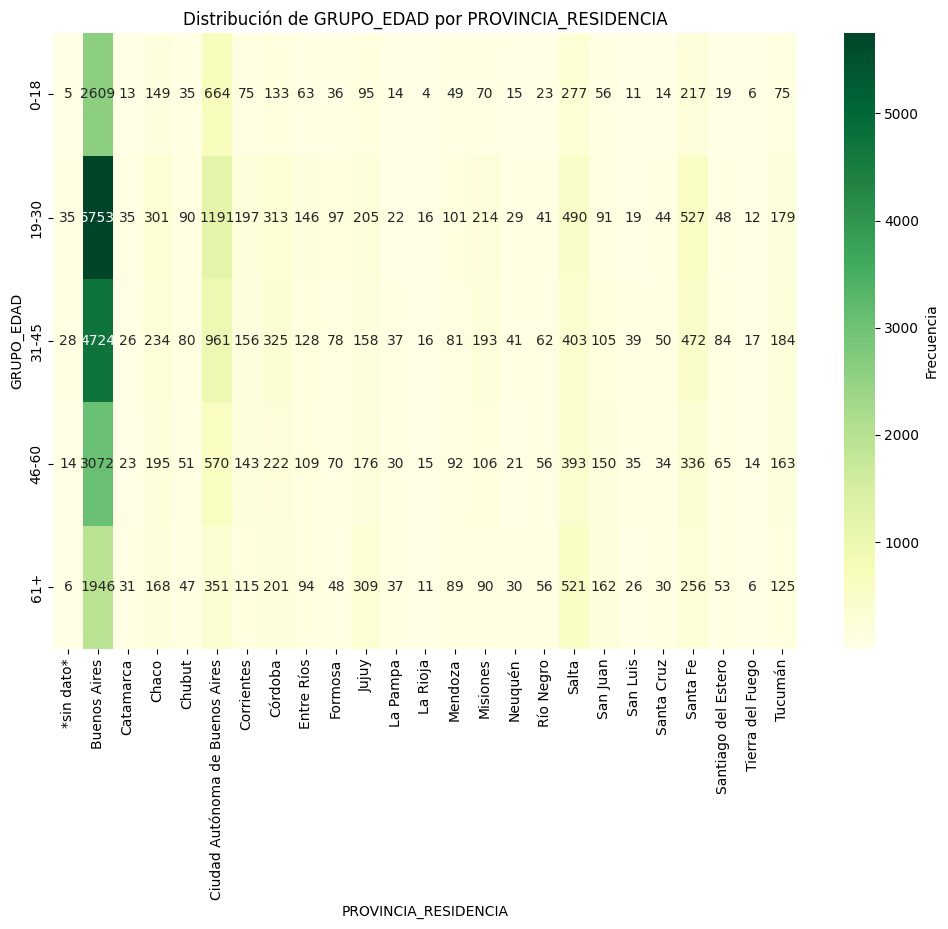

In [317]:
table = pd.crosstab(base['GRUPO_EDAD'], [base['PROVINCIA_RESIDENCIA']])

# Graficar el histograma de barras apiladas
plt.figure(figsize=(12, 8))
sns.heatmap(table, cmap='YlGn', annot=True, fmt='d', cbar=True, cbar_kws={'label': 'Frecuencia'})
plt.title('Distribución de GRUPO_EDAD por PROVINCIA_RESIDENCIA')
plt.xlabel('PROVINCIA_RESIDENCIA')
plt.ylabel('GRUPO_EDAD')

plt.show()


In [268]:
# Convierte la columna 'ANIO_NOTIFICACION' a formato datetime
base['ANIO_NOTIFICACION'] = pd.to_datetime(base['ANIO_NOTIFICACION'], format='%Y')

# Luego, puedes agrupar por año y momento de diagnóstico
tabla_agrupada = base.groupby([base['ANIO_NOTIFICACION'].dt.year, 'CLASIFICACION_PANDEMIA']).size().unstack(fill_value=0)

# Cambia los nombres de las columnas para mayor claridad
tabla_agrupada.columns = ['Antes de la pandemia', 'Después de la pandemia']

# Resetea el índice para tener una tabla con las columnas 'Año', 'Antes de la pandemia' y 'Después de la pandemia'
tabla_agrupada = tabla_agrupada.reset_index()

# Cambia el nombre de la columna del año
tabla_agrupada = tabla_agrupada.rename(columns={'ANIO_NOTIFICACION': 'Año'})

# Imprime la tabla agrupada
print(tabla_agrupada)

    Año  Antes de la pandemia  Después de la pandemia
0  2019                 12564                       0
1  2020                  2790                    7694
2  2021                     0                   11897


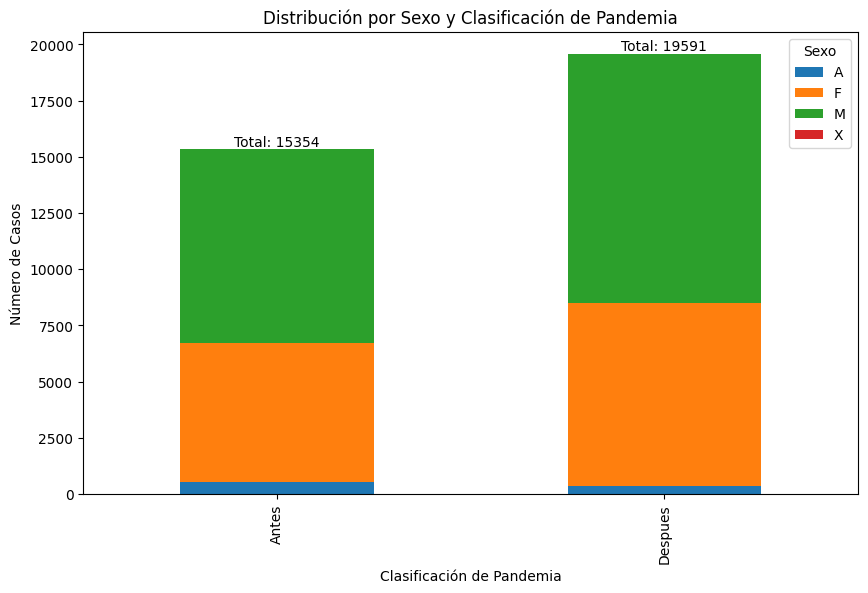

In [269]:
import pandas as pd
import matplotlib.pyplot as plt


# Agrupa los datos por 'SEXO' y 'CLASIFICACION_PANDEMIA', y cuenta el número de casos en cada grupo
grupo_distribucion = base.groupby(['CLASIFICACION_PANDEMIA', 'SEXO']).size().unstack(fill_value=0)

# Calcula el total de casos por sexo
total_por_sexo = base.groupby('CLASIFICACION_PANDEMIA').size()

# Crea un gráfico de barras apiladas
ax = grupo_distribucion.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configura las etiquetas y el título del gráfico
plt.xlabel('Clasificación de Pandemia')
plt.ylabel('Número de Casos')
plt.title('Distribución por Sexo y Clasificación de Pandemia')

# Agrega una leyenda
plt.legend(title='Sexo')

# Muestra el total de casos por sexo en la parte superior de las barras
for i, total in enumerate(total_por_sexo):
    plt.text(i, total, f'Total: {total}', ha='center', va='bottom')

# Muestra el gráfico
plt.show()


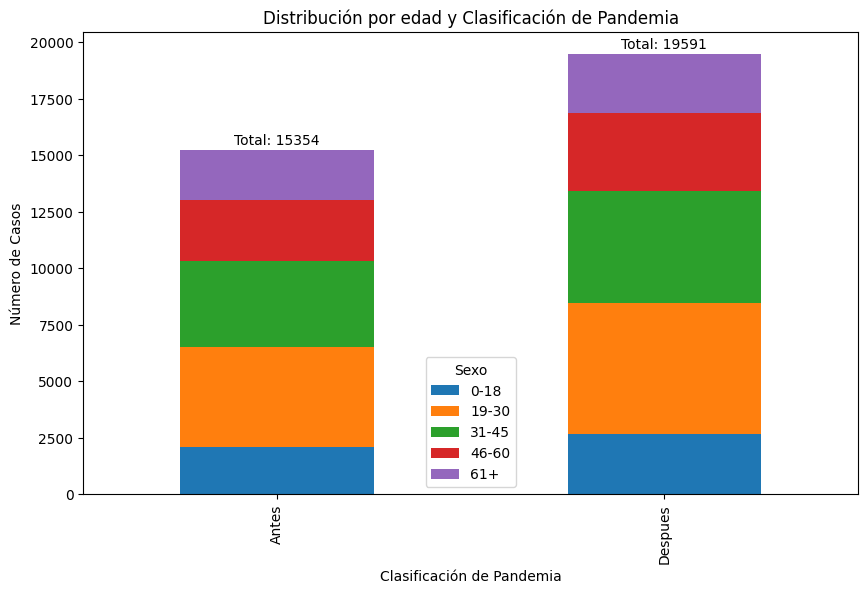

In [270]:

# Agrupa los datos por 'SEXO' y 'CLASIFICACION_PANDEMIA', y cuenta el número de casos en cada grupo
grupo_distribucion = base.groupby(['CLASIFICACION_PANDEMIA', 'GRUPO_EDAD'],  observed=False).size().unstack(fill_value=0)

# Calcula el total de casos por sexo
total_por_edad = base.groupby('CLASIFICACION_PANDEMIA').size()

# Crea un gráfico de barras apiladas
ax = grupo_distribucion.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configura las etiquetas y el título del gráfico
plt.xlabel('Clasificación de Pandemia')
plt.ylabel('Número de Casos')
plt.title('Distribución por edad y Clasificación de Pandemia')

# Agrega una leyenda
plt.legend(title='Sexo')

# Muestra el total de casos por sexo en la parte superior de las barras
for i, total in enumerate(total_por_edad):
    plt.text(i, total, f'Total: {total}', ha='center', va='bottom')

# Muestra el gráfico
plt.show()

C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\ProgramData\anaconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



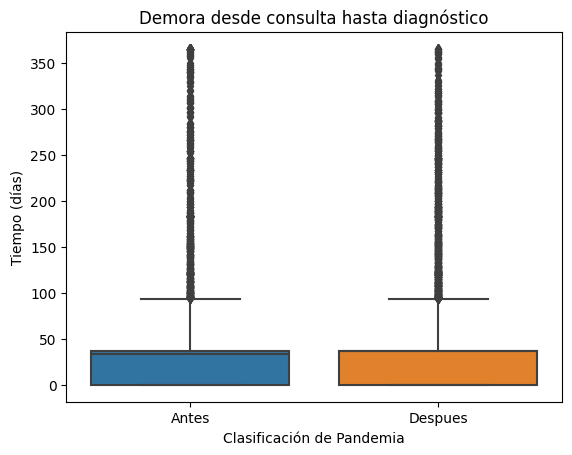

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir la columna 'CLASIFICACION_PANDEMIA' en un tipo de datos categórico en el DataFrame original
base['CLASIFICACION_PANDEMIA'] = base['CLASIFICACION_PANDEMIA'].astype('category')


# Crear el diagrama de caja por categoría
sns.boxplot(x='CLASIFICACION_PANDEMIA', y='TIEMPO_DEMORA', data=base)

# Añadir título y etiquetas a los ejes
plt.title('Demora desde consulta hasta diagnóstico')
plt.xlabel('Clasificación de Pandemia')
plt.ylabel('Tiempo (días)')

# Mostrar el diagrama
plt.show()

TIEMPO DEMORA DESDE QUE EL PACIENTE INICIO CON LOS SINTOMAS HASTA QUE SE DIAGNOSTICO

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
# Calcular las medidas de tendencia central para cada categoría segun clasificacion
valor_tiempo = round(base.groupby('CLASIFICACION_PANDEMIA')['TIEMPO_DEMORA'].agg(['mean', 'median']),2)


# Imprimir la tabla resumen
valor_tiempo

C:\Users\RominaSoledadDeLeon\AppData\Local\Temp\ipykernel_25796\864840934.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,mean,median
CLASIFICACION_PANDEMIA,,
Antes,27.39,34.00
Despues,29.01,37.24


In [147]:
# Calcular las medidas de tendencia central (media y mediana) para cada categoría según clasificación y provincia
valor_tiempo = round(base.groupby(['PROVINCIA_RESIDENCIA', 'CLASIFICACION_PANDEMIA'])['TIEMPO_DEMORA'].agg(['mean', 'median']).unstack(), 2)

# Renombrar las columnas
valor_tiempo.columns = ['Media_Antes', 'Media_Despues', 'Mediana_Antes', 'Mediana_Despues']

# Imprimir la tabla resumen
valor_tiempo




C:\Users\RominaSoledadDeLeon\AppData\Local\Temp\ipykernel_25796\2908731602.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Media_Antes,Media_Despues,Mediana_Antes,Mediana_Despues
PROVINCIA_RESIDENCIA,,,,
*sin dato*,17.14,28.23,0.00,21.62
Buenos Aires,26.58,27.79,37.24,37.24
Catamarca,22.24,10.27,37.24,0.00
Chaco,32.96,35.14,37.24,37.24
Chubut,22.02,19.52,7.00,1.00
Ciudad Autónoma de Buenos Aires,31.98,33.22,37.24,37.24
Corrientes,25.48,13.64,24.00,0.00
Córdoba,27.96,34.84,30.00,31.00
Entre Ríos,36.45,40.97,30.50,31.00


TIEMPO DEMORA DESDE QUE EL PACIENTE INICIO el TRATAMIENTO Y LO TERMINO

aca hay que tener en cuento la distribucion de la variable que se analiza simetrica (normal) asimetrico (no normal) si la media es mayor a la mediana y la moda por lo que se espera una distribución asimétrica a la derecha.

In [148]:
valor_tiempo_tto = round(base.groupby(['PROVINCIA_RESIDENCIA', 'CLASIFICACION_PANDEMIA'])['TIEMPO_DEMORA_TTO'].agg(['mean', 'median']).unstack(), 2)

# Renombrar las columnas
valor_tiempo_tto.columns = ['Media_Antes', 'Media_Despues', 'Mediana_Antes', 'Mediana_Despues']

# Imprimir la tabla resumen
valor_tiempo_tto

C:\Users\RominaSoledadDeLeon\AppData\Local\Temp\ipykernel_25796\1435971869.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Media_Antes,Media_Despues,Mediana_Antes,Mediana_Despues
PROVINCIA_RESIDENCIA,,,,
*sin dato*,190.30,183.20,204.5,204.5
Buenos Aires,196.27,196.87,204.5,204.5
Catamarca,199.58,172.74,204.5,192.0
Chaco,203.69,196.56,204.5,204.5
Chubut,210.93,199.85,204.5,204.5
Ciudad Autónoma de Buenos Aires,204.64,203.15,204.5,204.5
Corrientes,191.08,180.62,204.5,184.0
Córdoba,204.50,193.67,204.5,204.5
Entre Ríos,189.46,183.55,204.5,203.0


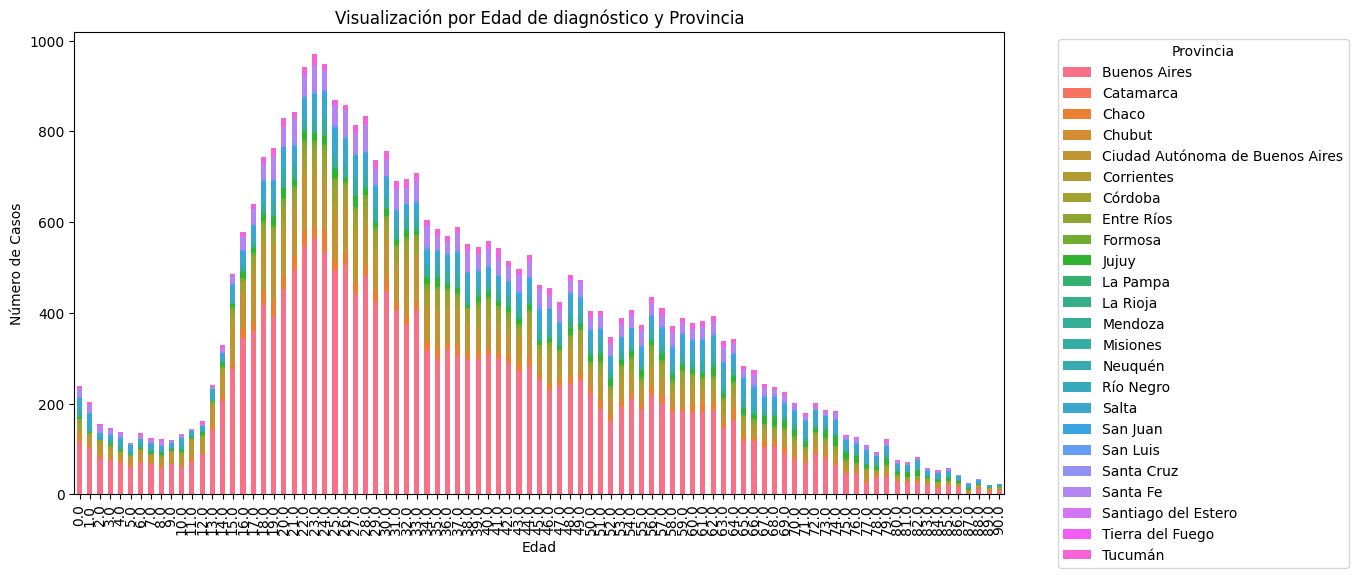

In [149]:
import matplotlib.pyplot as plt

paleta_colores = sns.color_palette('husl', n_colors=len(base['PROVINCIA_RESIDENCIA'].unique()))

# Por edad y provincias, contar las ocurrencias
agrupado = base[(~base['EDAD_DIAGNOSTICO'].isnull()) & (base['PROVINCIA_RESIDENCIA'] != "*sin dato*")].groupby(['EDAD_DIAGNOSTICO', 'PROVINCIA_RESIDENCIA']).size().unstack(fill_value=0)

# Crear un gráfico de barras apiladas
agrupado.plot(kind='bar', stacked=True, figsize=(12, 6), color=paleta_colores)
plt.title('Visualización por Edad de diagnóstico y Provincia')
plt.xlabel('Edad')
plt.ylabel('Número de Casos')
plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


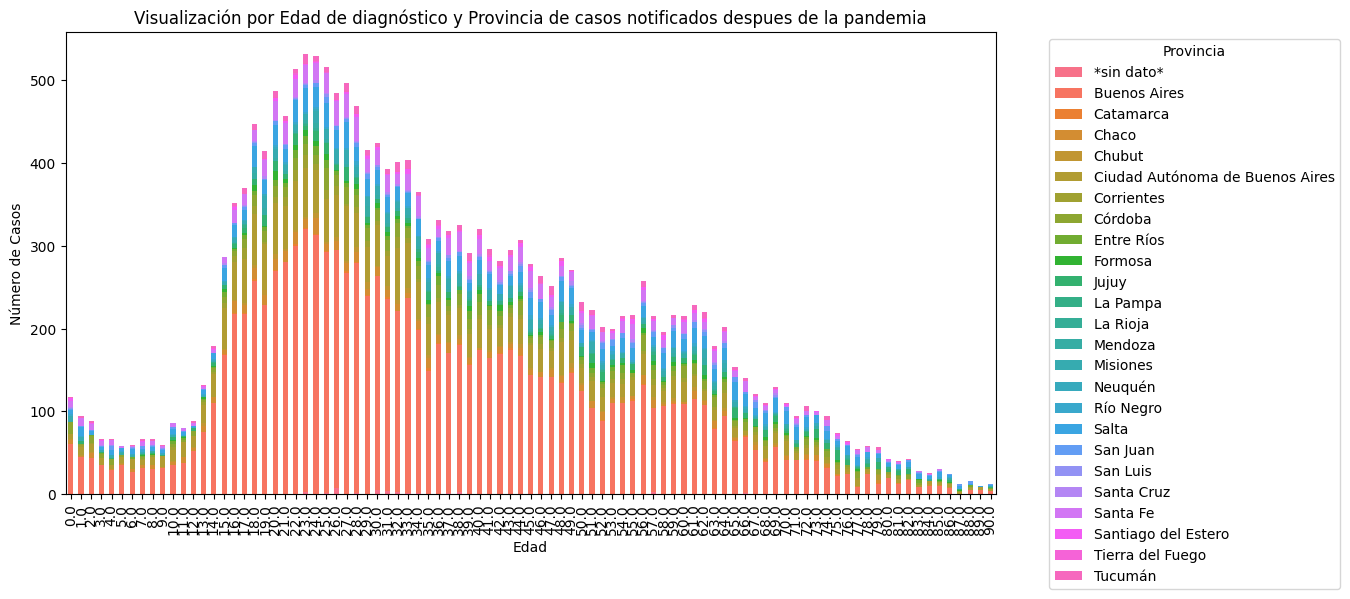

In [150]:
import matplotlib.pyplot as plt

paleta_colores = sns.color_palette('husl', n_colors=len(base['PROVINCIA_RESIDENCIA'].unique()))

# Por edad y provincias, contar las ocurrencias
agrupado = base[(~base['EDAD_DIAGNOSTICO'].isnull()) & (base['CLASIFICACION_PANDEMIA'] == "Despues")].groupby(['EDAD_DIAGNOSTICO', 'PROVINCIA_RESIDENCIA']).size().unstack(fill_value=0)

# Crear un gráfico de barras apiladas
agrupado.plot(kind='bar', stacked=True, figsize=(12, 6), color=paleta_colores)
plt.title('Visualización por Edad de diagnóstico y Provincia de casos notificados despues de la pandemia')
plt.xlabel('Edad')
plt.ylabel('Número de Casos')
plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

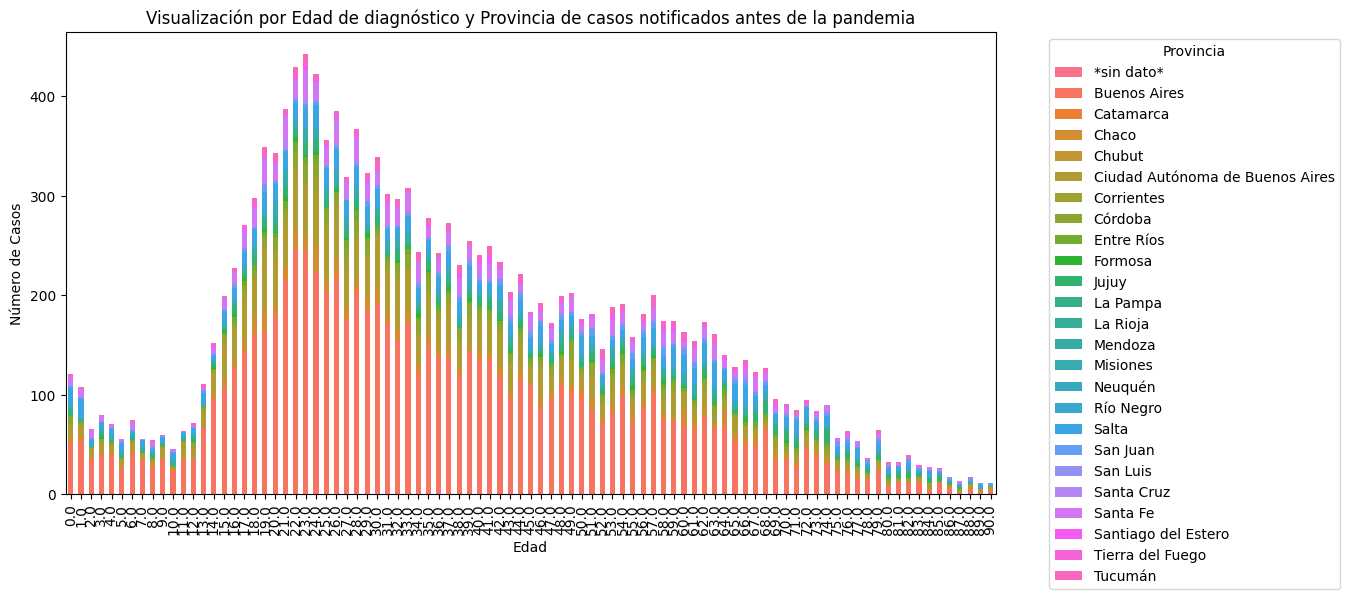

In [151]:
import matplotlib.pyplot as plt

paleta_colores = sns.color_palette('husl', n_colors=len(base['PROVINCIA_RESIDENCIA'].unique()))

# Por edad y provincias, contar las ocurrencias
agrupado = base[(~base['EDAD_DIAGNOSTICO'].isnull()) & (base['CLASIFICACION_PANDEMIA'] == "Antes")].groupby(['EDAD_DIAGNOSTICO', 'PROVINCIA_RESIDENCIA']).size().unstack(fill_value=0)

# Crear un gráfico de barras apiladas
agrupado.plot(kind='bar', stacked=True, figsize=(12, 6), color=paleta_colores)
plt.title('Visualización por Edad de diagnóstico y Provincia de casos notificados antes de la pandemia')
plt.xlabel('Edad')
plt.ylabel('Número de Casos')
plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [346]:
# Reemplazar "*sin dato*" con NaN (valores faltantes)
base['PROVINCIA_RESIDENCIA'] = base['PROVINCIA_RESIDENCIA'].replace('*sin dato*', pd.NA)

# Eliminar filas con NaN en 'PROVINCIA_RESIDENCIA'
base = base.dropna(subset=['PROVINCIA_RESIDENCIA'])

# Restablecer índice si es necesario
base = base.reset_index(drop=True)

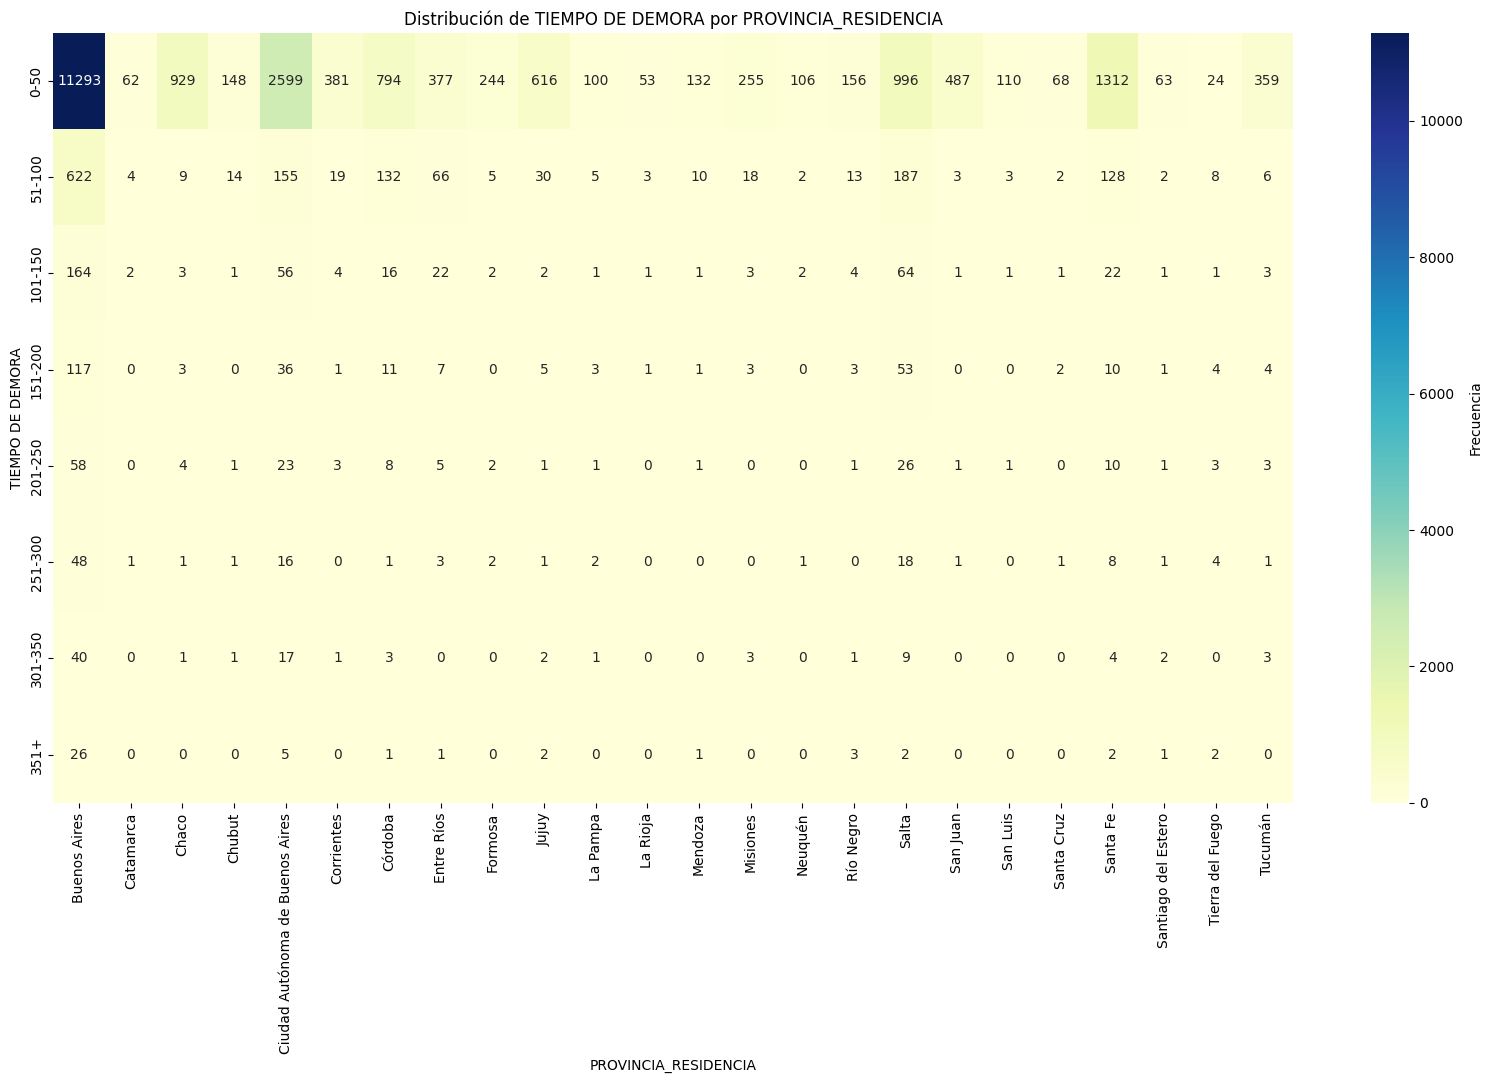

In [347]:
table1 = pd.crosstab(pd.cut(base['TIEMPO_DEMORA'], bins=[0, 50, 100, 150, 200, 250, 300, 350, float('inf')], 
                            labels=['0-50', '51-100', '101-150', '151-200', '201-250', '251-300', '301-350', '351+']),
                     base['PROVINCIA_RESIDENCIA'])

# Graficar el histograma de barras apiladas
plt.figure(figsize=(20, 10))
sns.heatmap(table1, cmap='YlGnBu', annot=True, fmt='d', cbar=True, cbar_kws={'label': 'Frecuencia'})
plt.title('Distribución de TIEMPO DE DEMORA por PROVINCIA_RESIDENCIA')
plt.xlabel('PROVINCIA_RESIDENCIA')
plt.ylabel('TIEMPO DE DEMORA')

plt.show()

C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



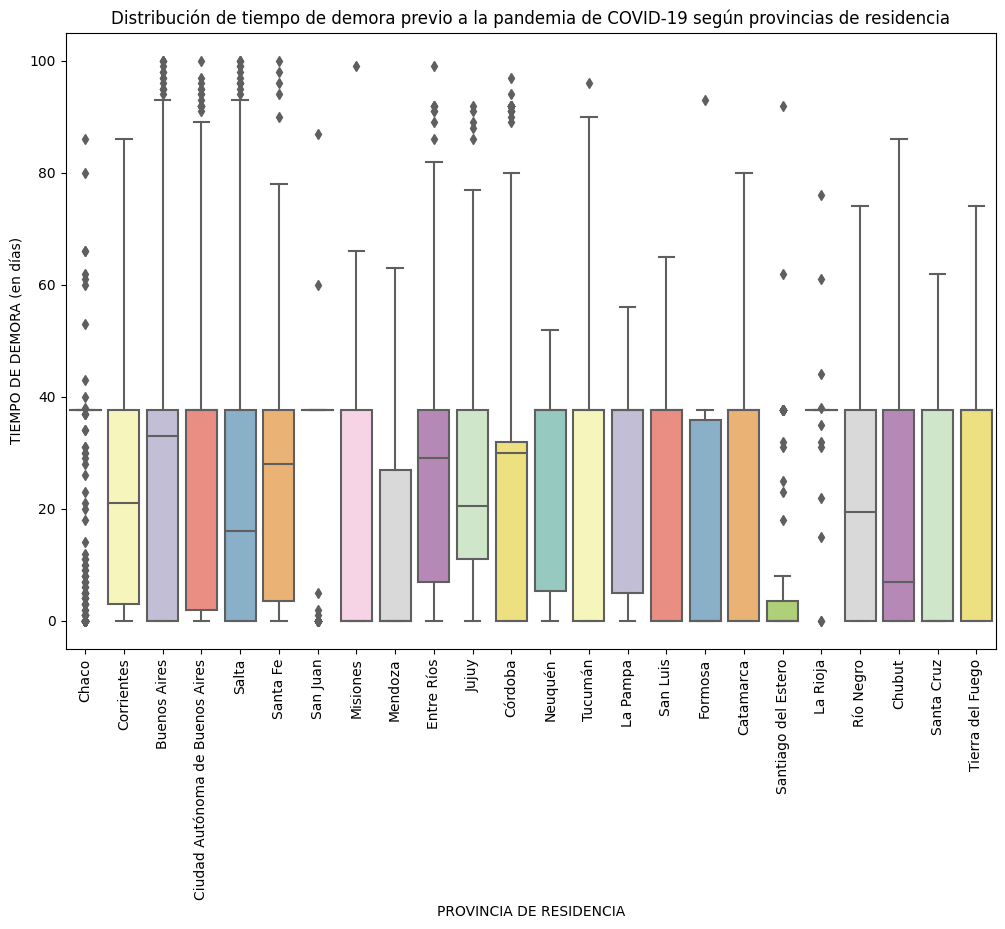

In [348]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el cuadro de cajas
plt.figure(figsize=(12, 8))
sns.boxplot(x='PROVINCIA_RESIDENCIA', y='TIEMPO_DEMORA', data=base[(base['TIEMPO_DEMORA'] <= 100) & (base['CLASIFICACION_PANDEMIA'] == 'Antes')],
            palette='Set3')
plt.title('Distribución de tiempo de demora previo a la pandemia de COVID-19 según provincias de residencia')
plt.xlabel('PROVINCIA DE RESIDENCIA')
plt.ylabel('TIEMPO DE DEMORA (en días)')
plt.xticks(rotation=90)
plt.show()


C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



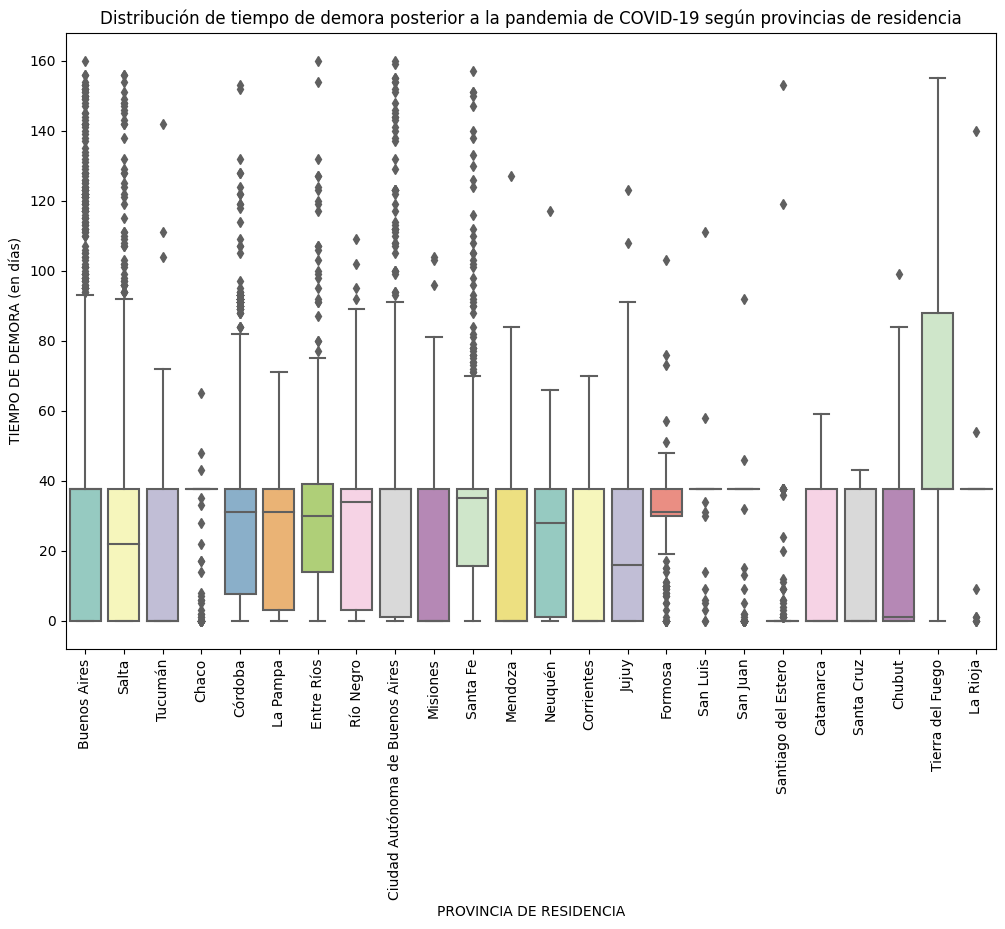

In [349]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el cuadro de cajas
plt.figure(figsize=(12, 8))
sns.boxplot(x='PROVINCIA_RESIDENCIA', y='TIEMPO_DEMORA', data=base[(base['TIEMPO_DEMORA'] <= 160) & (base['CLASIFICACION_PANDEMIA'] == 'Despues')],
            palette='Set3')
plt.title('Distribución de tiempo de demora posterior a la pandemia de COVID-19 según provincias de residencia')
plt.xlabel('PROVINCIA DE RESIDENCIA')
plt.ylabel('TIEMPO DE DEMORA (en días)')
plt.xticks(rotation=90)
plt.show()


In [152]:
!pip install contextily

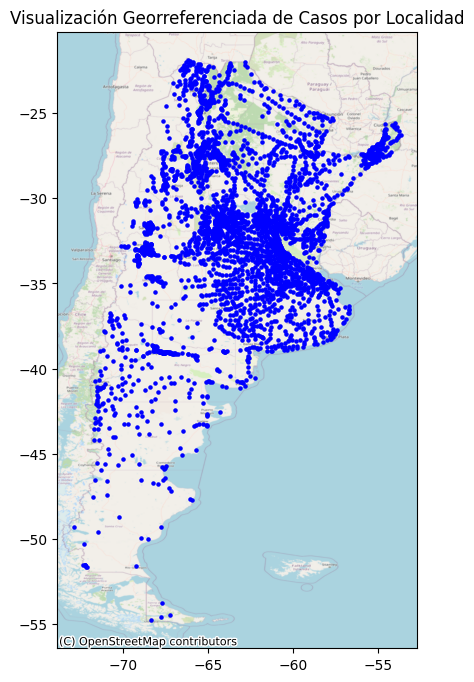

In [350]:
import contextily as ctx
import requests
# URL del archivo GeoJSON
url = "https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.31/download/localidades-censales.geojson"

# Descargo el geojson
response = requests.get(url)

# Guardo el archivo
with open("localidades-censales.geojson", "wb") as f:
    f.write(response.content)

# Cargop el archivo GeoJSON
gdf = gpd.read_file("localidades-censales.geojson")

# Fusiono gdf con base usando la columna 'nombre' para fusión
merged = gdf.merge(base, left_on='nombre', right_on='LOCALIDAD_RESIDENCIA')

# mapa de puntos
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, marker= 'o', color='blue', markersize=5)
ctx.add_basemap(ax, crs=merged.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)


plt.title('Visualización Georreferenciada de Casos por Localidad')
plt.show()


Georreferencia de cantidad de casos por provincia

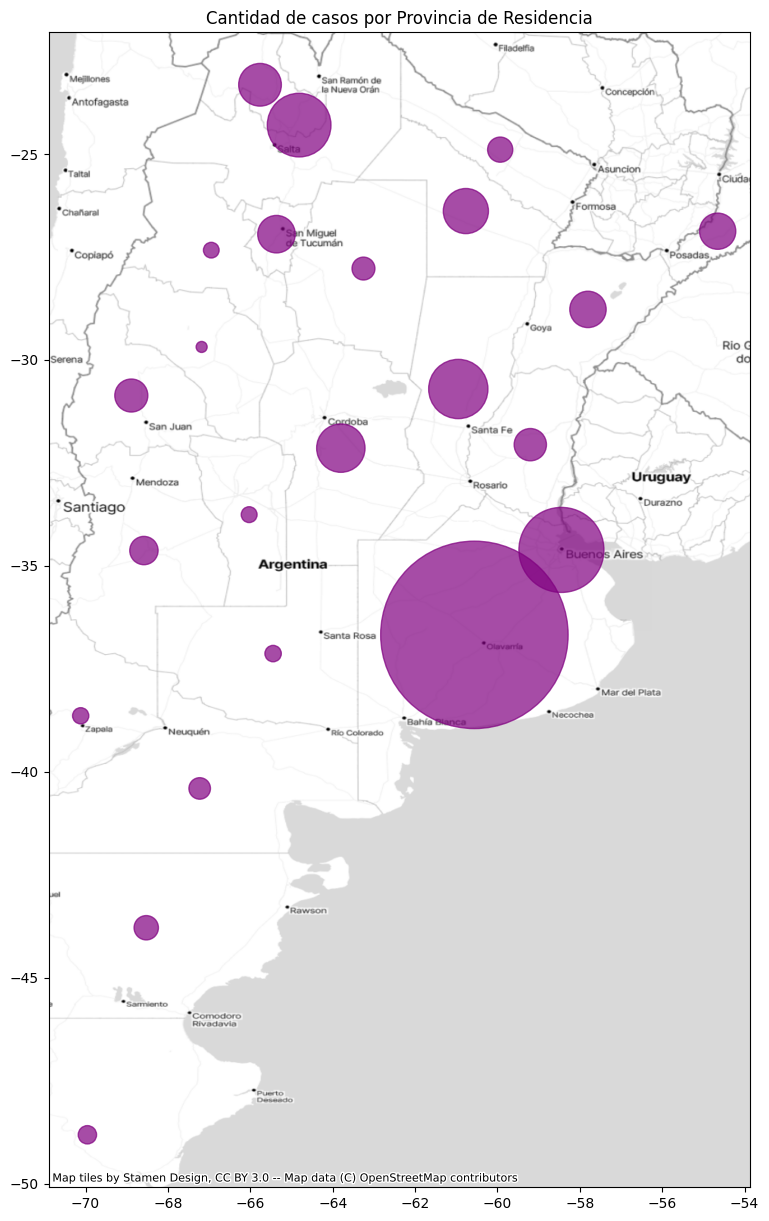

In [353]:
# URL del archivo GeoJSON
url = "https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.12/download/provincias.geojson"

# Descargo el geojson
response = requests.get(url)

# Guardo el archivo
with open("provincias.geojson", "wb") as f:
    f.write(response.content)

# Cargop el archivo GeoJSON
gdf = gpd.read_file("provincias.geojson")

# Realizo el conteo por provincia_residencia en el DataFrame base
conteo_provincias = base['PROVINCIA_RESIDENCIA'].value_counts().reset_index()
conteo_provincias.columns = ['PROVINCIA_RESIDENCIA', 'CANTIDAD']

# Fusiono el GeoDataFrame con los datos de conteo
merged = gdf.merge(conteo_provincias, left_on='nombre', right_on='PROVINCIA_RESIDENCIA')

# Creo gráfico
fig, ax = plt.subplots(figsize=(20,15))

# Escalo según el tamaño de los marcadores según 'CANTIDAD'
scaled_marker_size = merged['CANTIDAD'] * 1

# Graficar el mapa de puntos con el tamaño de los marcadores escalado
merged.plot(ax=ax, color='purple', markersize=scaled_marker_size, alpha=0.7)

# Añadir un mapa de fondo (contextily)
ctx.add_basemap(ax, crs=merged.crs.to_string(), source=ctx.providers.Stamen.TonerLite)

# Título del gráfico
plt.title('Cantidad de casos por Provincia de Residencia')

# Mostrar el gráfico
plt.show()


# lo que vienen lo deje para que pensemos que podemos hacer con eso no es necesario todo algo

Antes de hacer el análisis de covarianza, generamos un nuevo df quedándonos sólo con las variables que consideramos que más aportan al análisis


In [157]:
base.columns

Index(['ID_EVENTO', 'FECHA_APERTURA', 'SEPI_APERTURA', 'FECHA_PAPEL', 'SEXO',
       'NRO_DOC', 'FECHA_NACIMIENTO', 'EDAD_DIAGNOSTICO', 'IDPAISRESIDENCIA',
       'PAIS_RESIDENCIA', 'ID_PROV_INDEC_RESIDENCIA', 'PROVINCIA_RESIDENCIA',
       'ID_DEPTO_INDEC_RESIDENCIA', 'DEPARTAMENTO_RESIDENCIA',
       'ID_LOC_INDEC_RESIDENCIA', 'LOCALIDAD_RESIDENCIA', 'CALLE_DOMICILIO',
       'NUMERO_DOMICILIO', 'PAIS_NACIMIENTO', 'PERS_PRIV_LIBERTAD',
       'SERVICIO_PENITENCIARIO', 'CLASIFICACION_MANUAL',
       'CLASIFICACION_AUTOMATICA', 'SEPI_SINTOMA', 'FECHA_CONSULTA',
       'SEPI_CONSULTA', 'FECHA_INICIO_SINTOMA', 'EMBARAZADA', 'INTERNADO',
       'FECHA_INTERNACION', 'ID_SNVS_SIGNO_SINTOMA', 'SIGNO_SINTOMA',
       'CLASIFICACION_EXTRAPULMONAR', 'FIS', 'SEPI_MUESTRA', 'FTM',
       'FECHA_ESTUDIO', 'DETERMINACION', 'RESULTADO', 'FECHA_RECEPCION',
       'ID_ESTABLECIMIENTO_DIAG', 'ESTABLECIMIENTO_DIAG', 'ID_LOC_INDEC_DIAG',
       'LOCALIDAD_DIAG', 'ANTECEDENTE_EPIDEMIOLOGICO',
       'TIPO

<Axes: xlabel='TIEMPO_DEMORA_TTO', ylabel='TIEMPO_DEMORA'>

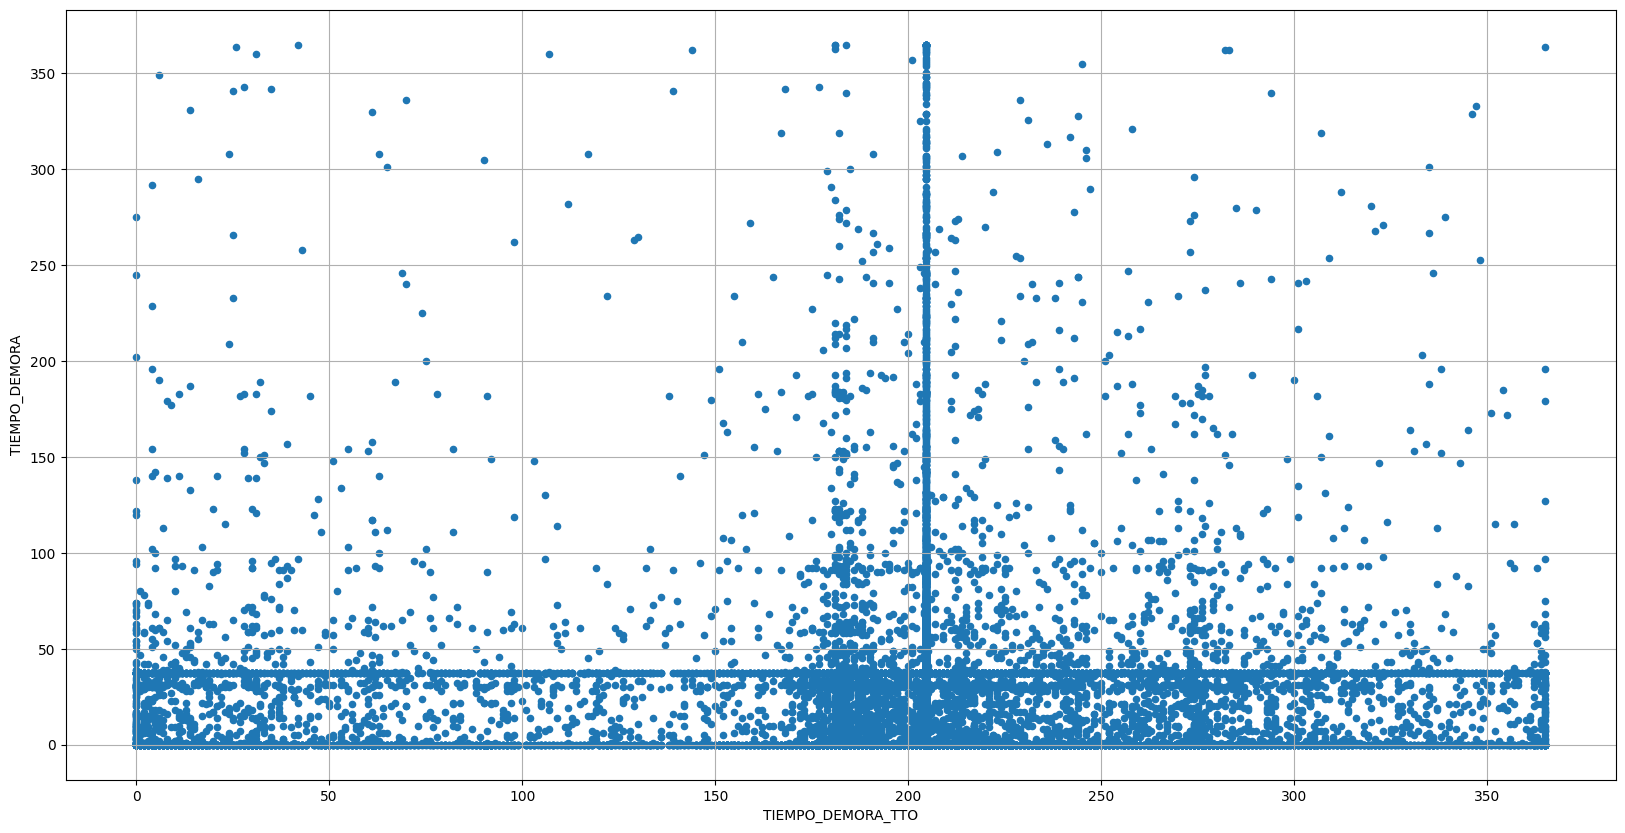

In [158]:
base.plot(kind='scatter',x='TIEMPO_DEMORA_TTO',y='TIEMPO_DEMORA',grid=True,figsize=(20,10))

In [159]:
df_cuantitativas =base[['TIEMPO_DEMORA', 'TIEMPO_DEMORA_TTO','EDAD_DIAGNOSTICO']]

Análisis de covarianza entre las variables.
Del análisis de la covarianza se puede ver que edad tiene una covarianza positiva con tiempo de demora del diagnostico y negativa con tiempo de demora del trataeminto (MAYOR EDAD MENOR TIEMPO TTO Y MAYOR EDAD MAYOR TIEMPO DE DIAGNOSTICO??)

<Axes: >

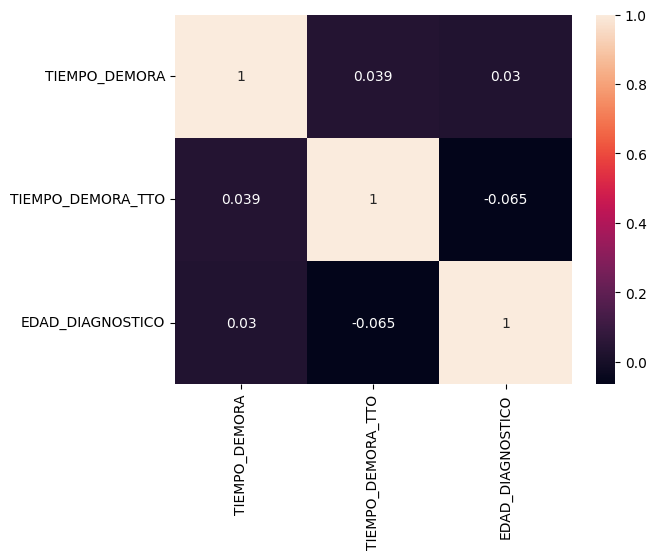

In [160]:
sns.heatmap(df_cuantitativas.corr(),annot=True)

3. Aprendizaje supervisado:

Para predecir la demora en el diagnóstico.

Regresión lineal multivariado
Aplicamos un modelo de regresión lineal MULTIVARIADO buscando predecir el teimpo de demora del tratamiento según la edad del paciente y tiempo de demora del diagnostico

In [161]:
!pip install statsmodels

In [162]:
#Importamos el módulo que necesitamos
import statsmodels.formula.api as smf

#Construimos el modelo.
lm = smf.ols(formula='TIEMPO_DEMORA_TTO''~EDAD_DIAGNOSTICO + TIEMPO_DEMORA',data=df_cuantitativas).fit()

In [163]:
y = np.array(df_cuantitativas['TIEMPO_DEMORA_TTO'])

In [164]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:      TIEMPO_DEMORA_TTO   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     103.7
Date:                Tue, 26 Sep 2023   Prob (F-statistic):           1.23e-45
Time:                        14:19:26   Log-Likelihood:            -1.9192e+05
No. Observations:               34916   AIC:                         3.838e+05
Df Residuals:                   34913   BIC:                         3.839e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          202.4430      0.737  

El valor de *R-cuadrado *es 0.005, lo que significa que aproximadamente el 0.5% de la variabilidad de la variable "demora en el tratamiento", esto se explicaría por las variables incluidas en el modelo.

El *R-cuadrado ajustado *es 0.005, lo que indica que el ajuste del modelo no mejora al considerar el número de variables y observaciones.

El valor p es muy pequeño (2.88e-41), lo que indica que hay evidencia significativa para rechazar la hipótesis nula de que no hay relación lineal entre las variables independientes y la variable dependiente. ENTONCES QUIERE DECIR QUE HAY RELACION ENTRE LA DEMORA EN EL TRATAMIENTO AL EDAD DEL PACIENTE Y EL TIEMPO EN QUE DEMORO EN SER DIAGNOSTICADO



---



---


**Bosques aleatorios para árboles de regresión.**


---

---


In [165]:
#Vamos a buscar el método adecuado
from sklearn.ensemble import RandomForestRegressor

In [166]:
#Generamos nuestra instancia
#En el parámetro n_estimators le decimos la cantidad de árboles aleatorios queremos que genere.
forest1= RandomForestRegressor(n_jobs=2,oob_score=True,n_estimators=5000)

In [167]:
X = base.copy()
tipos_a_mantener = ['int64', 'float64']

# Seleccionar las columnas que son de los tipos especificados
X = X.select_dtypes(include=tipos_a_mantener)
y = base['TIEMPO_DEMORA']  # Definir la columna objetivo

In [168]:
X = X.dropna(axis=1)

In [169]:
y = y.dropna()

In [170]:
#Ajustamos nuestro modelo
forest1.fit(X,y)

RandomForestRegressor(n_estimators=5000, n_jobs=2, oob_score=True)

In [171]:
#Podemos ver nuestras predicciones.
forest1.oob_prediction_[:10]

array([  0.        ,   7.        ,  37.23625606, 332.77595628,
        18.        ,  37.23625606,  37.23625606,  37.23625606,
        37.23625606,  37.23625606])

In [172]:
print(" El r2 del modelo es: " , forest1.score(X, y)*100)

 El r2 del modelo es:  99.99997907916955


El R2 de los bosques aleatorios para árbol de regresión nos da 0.85 es decir que aproximadamente el 85 % de la variabilidad de los valores de respuesta se explica por las variables predictoras utilizadas en el modelo.

Esta alta proporción de variabilidad sugiere que el modelo de bosques aleatorios tiene un buen ajuste a los datos y es capaz de capturar la relación entre las variables predictoras y la de respuesta.

En otras palabras, el modelo es capaz de predecir con bastante precisión los valores de la variable de respuesta basándose en las variables predictoras.


---


**Clasificación - KNN**


---


El algoritmo k-NN es un método de aprendizaje supervisado que clasifica los puntos de datos en función de la mayoría de votos de sus k vecinos más cercanos en el espacio de características. Es sencillo de entender e implementar, y puede funcionar bien en conjuntos de datos pequeños. Sin embargo, puede ser computacionalmente costoso para conjuntos de datos grandes y puede no funcionar bien cuando los datos tienen características irrelevantes o ruido.
Los algoritmos de clasificación se utilizan cuando el resultado deseado es una etiqueta discreta.

In [173]:
#Importamos las librerias necesarias
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import preprocessing,neighbors

In [174]:
base.columns

Index(['ID_EVENTO', 'FECHA_APERTURA', 'SEPI_APERTURA', 'FECHA_PAPEL', 'SEXO',
       'NRO_DOC', 'FECHA_NACIMIENTO', 'EDAD_DIAGNOSTICO', 'IDPAISRESIDENCIA',
       'PAIS_RESIDENCIA', 'ID_PROV_INDEC_RESIDENCIA', 'PROVINCIA_RESIDENCIA',
       'ID_DEPTO_INDEC_RESIDENCIA', 'DEPARTAMENTO_RESIDENCIA',
       'ID_LOC_INDEC_RESIDENCIA', 'LOCALIDAD_RESIDENCIA', 'CALLE_DOMICILIO',
       'NUMERO_DOMICILIO', 'PAIS_NACIMIENTO', 'PERS_PRIV_LIBERTAD',
       'SERVICIO_PENITENCIARIO', 'CLASIFICACION_MANUAL',
       'CLASIFICACION_AUTOMATICA', 'SEPI_SINTOMA', 'FECHA_CONSULTA',
       'SEPI_CONSULTA', 'FECHA_INICIO_SINTOMA', 'EMBARAZADA', 'INTERNADO',
       'FECHA_INTERNACION', 'ID_SNVS_SIGNO_SINTOMA', 'SIGNO_SINTOMA',
       'CLASIFICACION_EXTRAPULMONAR', 'FIS', 'SEPI_MUESTRA', 'FTM',
       'FECHA_ESTUDIO', 'DETERMINACION', 'RESULTADO', 'FECHA_RECEPCION',
       'ID_ESTABLECIMIENTO_DIAG', 'ESTABLECIMIENTO_DIAG', 'ID_LOC_INDEC_DIAG',
       'LOCALIDAD_DIAG', 'ANTECEDENTE_EPIDEMIOLOGICO',
       'TIPO

##me da error tengo que ver que es

In [175]:
#Seleccionemos la variable preparamos los datos

Y = base['CLASIFICACION_PANDEMIA']

X = base[['TIEMPO_DEMORA', 'TIEMPO_DEMORA_TTO', 'EDAD_DIAGNOSTICO']]

#Veamos nuestras variables para
X.shape

(34916, 3)

In [176]:
Y.shape

(34916,)

In [177]:
Y.unique()

['Antes', 'Despues']
Categories (2, object): ['Antes', 'Despues']

In [178]:
#Dividimos el conjunto de datos para entrenar nuestro modelo
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [179]:
#Generamos nuestra instancia de modelo # N_neighbors determinar el K del KNN a entrenar.
#se utiliza una métrica de distancia apropiada para variables categóricas, como la distancia de Hamming
#o la distancia de Jaccard.
clf = neighbors.KNeighborsClassifier(n_neighbors=5)

In [180]:
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [181]:
#Veamos la precisión
accuracy = clf.score(X_test,y_test)
accuracy
print("Precisión:", accuracy)

Precisión: 0.5379438717067583


Una precision de 0,22 podemos decir que el resultado no es bueno, es decir que el modelo predijo correctametne solo el 22% de los barrios

Enntoces probamos con otras modelos o tecnicas como arboles o bosques son algoritmos de clasificación que pueden ser útiles en problemas de predicción de etiquetas discretas.

In [182]:
from sklearn.impute import SimpleImputer  # Importar el imputador

# Dividir los datos en conjunto de entrenamiento y prueba
X = base[['EDAD_DIAGNOSTICO']]  # Característica de entrada (en este caso, edad de diagnóstico)
y = base['TIEMPO_DEMORA']  # Variable objetivo (tiempo de diagnóstico)

# Imputar valores faltantes en 'y' usando la media
imputer = SimpleImputer(strategy='mean')
y = imputer.fit_transform(y.values.reshape(-1, 1))

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluar el rendimiento del modelo
score = model.score(X_test, y_test)
print(f'R-cuadrado del modelo: {score}')

R-cuadrado del modelo: 0.0005509894233183266





4. Aprendizaje no supervisado:

El aprendizaje no supervisado puede ser útil para identificar patrones en los datos. Podrías usar técnicas de clustering como K-means para agrupar pacientes en función de características similares, lo que podría ayudar a identificar subgrupos de pacientes con demoras similares en el diagnóstico.

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



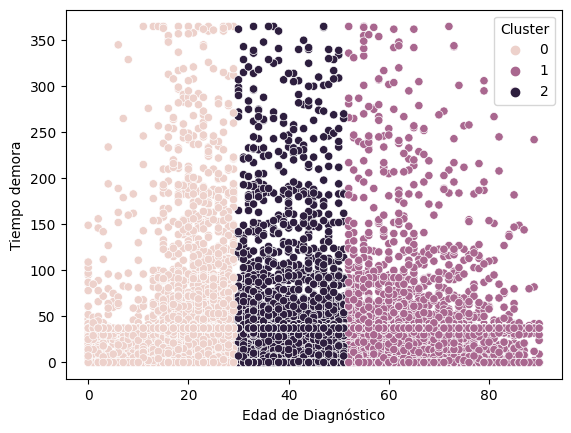

In [183]:
# Supongamos que deseas agrupar en 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
base['Cluster'] = kmeans.fit_predict(X)

# Visualizar los clusters
sns.scatterplot(data=base, x='EDAD_DIAGNOSTICO', y='TIEMPO_DEMORA', hue='Cluster')
plt.xlabel('Edad de Diagnóstico')
plt.ylabel('Tiempo demora')
plt.show()


## No sé si sirven de mucho!

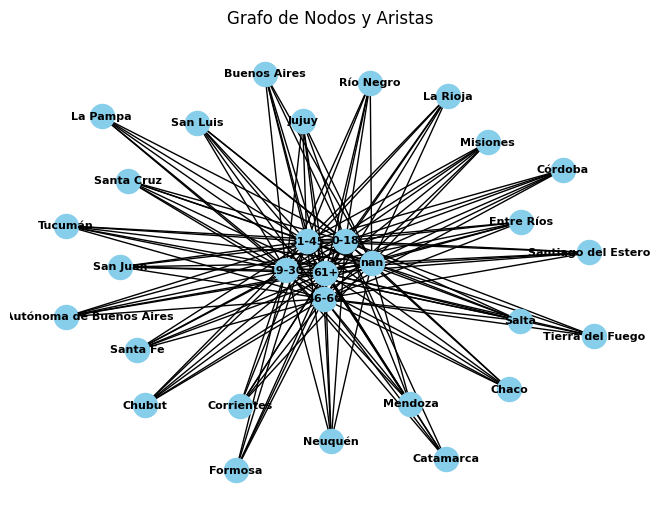

In [358]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un objeto de grafo
G = nx.Graph()

# Agregar nodos para grupos de edad
grupos_de_edad = base['GRUPO_EDAD'].unique()
for grupo in grupos_de_edad:
    G.add_node(grupo, tipo='Grupo de Edad')

# Agregar nodos para provincias de residencia
provincias_residencia = base['PROVINCIA_RESIDENCIA'].unique()
for provincia in provincias_residencia:
    G.add_node(provincia, tipo='Provincia de Residencia')

# Agregar aristas para representar relaciones (por ejemplo, cuántas personas de un grupo de edad viven en una provincia)
for _, row in base.iterrows():
    G.add_edge(row['GRUPO_EDAD'], row['PROVINCIA_RESIDENCIA'])

# Dibujar el grafo
pos = nx.spring_layout(G, seed=42)  # Colocación de nodos en el plano
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=8, font_color='black', font_weight='bold')

# Mostrar el grafo
plt.title("Grafo de Nodos y Aristas")
plt.show()

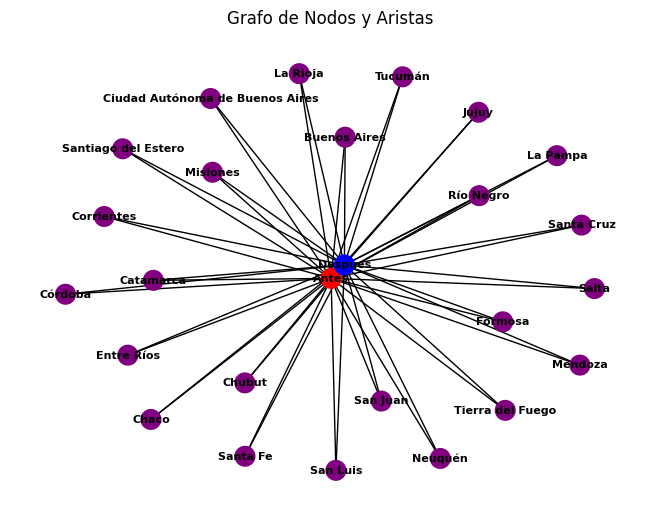

In [356]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un objeto de grafo
G = nx.Graph()

# Agregar nodos para CLASIFICACION_PANDEMIA
clasificacion_pandemia_values = base['CLASIFICACION_PANDEMIA'].unique()
for clasificacion_pandemia in clasificacion_pandemia_values:
    G.add_node(clasificacion_pandemia, tipo='Clasificación Pandemia')

# Agregar nodos para PROVINCIA_RESIDENCIA
provincia_residencia_values = base['PROVINCIA_RESIDENCIA'].unique()
for provincia_residencia in provincia_residencia_values:
    G.add_node(provincia_residencia, tipo='Provincia de Residencia')

# Asignar colores directamente a las categorías 'Antes' y 'Después' de 'CLASIFICACION_PANDEMIA'
colores = {'Antes': 'red', 'Despues': 'blue'}

# Agregar aristas según alguna lógica específica (aquí, un ejemplo simple)
for _, row in base.iterrows():
    G.add_edge(row['CLASIFICACION_PANDEMIA'], row['PROVINCIA_RESIDENCIA'])

# Obtener los colores de los nodos en función de 'CLASIFICACION_PANDEMIA'
node_colors = [colores.get(clasificacion, 'purple') for clasificacion in G.nodes]

# Dibujar el grafo con colores asignados
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=200, node_color=node_colors, font_size=8, font_color='black', font_weight='bold')
plt.title("Grafo de Nodos y Aristas")
plt.show()
